In [129]:
import sys
import os
if os.getenv('RBMHOME') != None:
    os.chdir(os.getenv('RBMHOME'))
sys.path.append(os.getcwd() + '/src')
sys.path.append(os.getcwd() + '/src/RBMs')
import importlib
import importlib
import torch
from torch.nn.functional import one_hot
import scores
from h5py import File
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
from matplotlib import cm
from tqdm import tqdm
import gzip
from matplotlib.colors import to_hex
import h5py
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec

In [3]:
# use LaTeX fonts in the plots
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({'font.size': 15})
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}'
plt.rcParams['legend.title_fontsize'] = 'xx-small'

In [4]:
# to change
device = torch.device('cuda:1')
model = 'models/GH30_annotated/PottsBernoulliSslRBM-2023.7.5.17.4-GH30_annotated-ep30000-lr0.01-Nh300-NGibbs10-mbs1000-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-Rdm.h5'
data_name = 'GH30'
data_set = 'train'
cmap = 'tab10'

#folder_name = f'results/FeF_scores/FeF_scores-{data_name}-Nh300-train'
#os.mkdir(folder_name)
gen_time = 100
num_samples = -1
num_points_trajectory = 50
batch_size = 300
replication_factor = 2

In [107]:
# import data and RBM model
f_model = File(model, 'r')
fname_data = f_model['dataset_filename'][()].decode('utf8')
f_data = File(fname_data, 'r')

# create the direcory where to store the results if it does not already exist.
model_stamp = f_model['model_stamp'][()].decode('utf8')
# the Potts-RBM requires the input data to be of type int64, while the Bernoulli-RBM requires float32
if 'Potts' in model_stamp:
    data_type = torch.int64
else:
    data_type = torch.float32

# specify the ages of the model to use
alltime = f_model['alltime'][()]
t_age = alltime[-1]

# Import the dataset
allD = torch.tensor(f_data[data_set][()]).type(data_type)
allLabels_string = f_data[data_set + '_labels'].asstr()[()]
if num_samples != -1:
    idxs = np.random.choice(np.arange(allD.shape[0]), num_samples, replace=False)
    allD = allD[idxs].to(device)
    allLabels_string = allLabels_string[idxs]
else:
    allD = allD.to(device)

# Take only the data that have a label
filtered_idxs = np.where((allLabels_string != '-1'))[0]
allLabels_string_filtered = allLabels_string[filtered_idxs]
label2category = {lab : i for i, lab in enumerate(np.unique(allLabels_string_filtered))}
category2label = {i : lab for i, lab in enumerate(np.unique(allLabels_string_filtered))}
labels_data = np.array(([label2category[lab] for lab in allLabels_string_filtered]))
labels_data2counts = {l : c for l, c in zip(*np.unique(labels_data, return_counts=True))}
# Take the labels present in the dataset and repeat them replication_factor times to produce the targets
targets_oversampled = torch.tensor(labels_data, device=device, dtype=torch.int64).repeat(replication_factor)
targets_prediction = torch.tensor(labels_data, device=device) # used for computing the accuracy of the predictions
D = allD[filtered_idxs]
ndata = D.shape[0]
if batch_size > ndata:
    batch_size = -1
    
unique_labels, label_counts = torch.unique(targets_prediction, return_counts=True)
unique_labels = unique_labels.cpu().numpy()
n_categories = unique_labels.shape[0]
print(f'\nExtracted {ndata} labelled samples from the dataset.')
if 'Potts' in model_stamp:
    D_oh = one_hot(D).reshape(ndata, -1).type(torch.float32)
else:
    D_oh = D

# import the proper model
model_identifier = f_model['model_stamp'][()].decode('utf8').split('-')[0]
RBM = importlib.import_module(model_identifier).RBM
rbm = RBM(device=device)
rbm.loadRBM(model, stamp=t_age)
f_data.close()
f_model.close()


Extracted 3922 labelled samples from the dataset.


In [108]:
# compute observables on the dataset
entropy_D_label = {category2label[l] : 0 for l in unique_labels}
for label in unique_labels:
    mask = np.where(labels_data == label)[0]
    entropy_D_label[category2label[label]] = len(gzip.compress(D[mask].int().cpu().numpy())) / len(mask)
    
D_lengths = torch.sum(D != 0, dim=1).cpu().numpy()
D_lengths_mean = D_lengths.mean()
D_lengths_std = D_lengths.std()

# label-specific scores containers: list({label : score_trajectory}) of t_ages
scores_LL = []
scores_spectra = []
scores_AAI = []
scores_entropy = []
scores_AAI_data = []
scores_AAI_gen = []
scores_first_moment = []
scores_second_moment = []

# Define the generation times at which evaluating the model
exponent = int(np.log10(gen_time))
record_times = np.unique(np.logspace(0, exponent, num_points_trajectory).astype(np.int64))
record_times = np.unique(np.sort(np.append([0, rbm.gibbs_steps], record_times)))
# For tracking all the generation process
if num_points_trajectory == gen_time:
    record_times = np.arange(0, num_points_trajectory + 1)
    
# dict(label : score_trajectory)
score_LL_dict = {category2label[l] : [] for l in unique_labels}
score_spectra_dict = {category2label[l] : [] for l in unique_labels}
score_AAI_dict = {category2label[l] : [] for l in unique_labels}
score_entropy_dict = {category2label[l] : [] for l in unique_labels}
score_AAI_data_dict = {category2label[l] : [] for l in unique_labels}
score_AAI_gen_dict = {category2label[l] : [] for l in unique_labels}
score_first_moment_dict = {category2label[l] : [] for l in unique_labels}
score_second_moment_dict = {category2label[l] : [] for l in unique_labels}

In [109]:
G_oversampled = torch.randint(0, rbm.num_states, size=(targets_oversampled.shape[0], D.shape[1]), device=device, dtype=data_type)
predictions = torch.randint(0, rbm.num_categ, (D.shape[0],), device=device, dtype=torch.int64)
pbar = tqdm(desc='Evaluating age {0}'.format(t_age), total=len(record_times) - 1, leave=False, colour='red', dynamic_ncols=True, ascii='-#')
for tg_index in range(1, len(record_times)):
    dt = (record_times[tg_index] - record_times[tg_index - 1])
    G_oversampled, _, _, _ = rbm.conditioned_sampling(G_oversampled, targets_oversampled, it_mcmc=dt, batch_size=batch_size)
    predictions = rbm.predict(D, predictions, it_mcmc=dt, batch_size=batch_size).argmax(-1)
    
    # remove duplicates
    G_oversampled_unique, unique_idxs = np.unique(G_oversampled.cpu().numpy(), axis=0, return_index=True)
    G_oversampled_unique = torch.from_numpy(G_oversampled_unique).to(device) # Caution: as it is, this tensor is sorted, i.e., biased
    targets_oversampled_unique = targets_oversampled[unique_idxs].cpu().numpy()
    
    # extract from the generated set, for each label, the same number of samples present in the datset
    G = []
    gen_labels = []
    gen_labels2count = {l : 0 for l in unique_labels}
    for g, l in zip(G_oversampled_unique, targets_oversampled_unique):
        if not torch.any(torch.all(g == D, dim=1)):
            if gen_labels2count[l] < labels_data2counts[l]:
                G.append(g.unsqueeze(0))
                gen_labels.append(l)
                gen_labels2count[l] += 1
    
    G = torch.cat(G, 0).to(device)
    gen_labels = np.array(gen_labels)
                           
    if 'Potts' in model_stamp:
        G_oh = one_hot(G).reshape(G.shape[0], -1).type(torch.float32)
    else:
        G_oh = G
    
    for label in unique_labels:
        idxs_G = np.where(gen_labels == label)[0]
        idxs_D = np.where(labels_data == label)[0]
        
        if len(idxs_G) >= len(idxs_D):
            random_choice = np.random.choice(np.arange(len(idxs_G)), len(idxs_D), replace=False)
            idxs_G = idxs_G[random_choice]
        else:
            sys.stderr.flush()
            print(f'Warning: label {category2label[label]} has {len(idxs_G)} samples in generated and {len(idxs_D)} samples in data. You may want to increase the replication_factor.')
            random_choice = np.random.choice(np.arange(len(idxs_D)), len(idxs_G), replace=False)
            idxs_D = idxs_D[random_choice]
        
        LL = scores.LL_score_batched_Ssl(D[idxs_D], labels_data[idxs_D], G[idxs_G], gen_labels[idxs_G], rbm, batch_size).cpu()
        score_LL_dict[category2label[label]].append(LL)
        
        spectra = scores.spectrum_score(D_oh[idxs_D], G_oh[idxs_G]).cpu()
        score_spectra_dict[category2label[label]].append(spectra)
        
        AAI_data, AAI_gen = scores.AAI_score(D_oh[idxs_D], G_oh[idxs_G])
        AAI = (AAI_data - 0.5)**2 + (AAI_gen - 0.5)**2
        score_AAI_dict[category2label[label]].append(AAI.cpu().numpy())
        score_AAI_data_dict[category2label[label]].append(AAI_data.cpu().numpy())
        score_AAI_gen_dict[category2label[label]].append(AAI_gen.cpu().numpy())
        
        entropy = scores.entropy_score(entropy_D_label[category2label[label]], G[idxs_G])
        score_entropy_dict[category2label[label]].append(entropy)
        
        first_moment = scores.first_moment_score(D_oh[idxs_D], G_oh[idxs_G]).cpu()
        score_first_moment_dict[category2label[label]].append(first_moment)
        
        second_moment = scores.second_moment_score(D_oh[idxs_D], G_oh[idxs_G]).cpu()
        score_second_moment_dict[category2label[label]].append(second_moment)
    
    pbar.update(1)
record_times = record_times[1:]
sys.stderr.flush()

In [102]:
#record_times = record_times[1:]

In [110]:
# save the data

f = h5py.File(folder_name + '/score_LL.h5', 'w')
for key, value in score_LL_dict.items():
    f[key] = np.array(value)
f.close()

f = h5py.File(folder_name + '/score_spectra.h5', 'w')
for key, value in score_spectra_dict.items():
    f[key] = np.array(value)
f.close()

f = h5py.File(folder_name + '/score_entropy.h5', 'w')
for key, value in score_entropy_dict.items():
    f[key] = np.array(value)
f.close()

f = h5py.File(folder_name + '/score_AAI.h5', 'w')
for key, value in score_AAI_dict.items():
    f[key] = np.array(value)
f.close()

f = h5py.File(folder_name + '/score_first_moment.h5', 'w')
for key, value in score_first_moment_dict.items():
    f[key] = np.array(value)
f.close()

f = h5py.File(folder_name + '/score_second_moment.h5', 'w')
for key, value in score_first_moment_dict.items():
    f[key] = np.array(value)
f.close()

## Plot

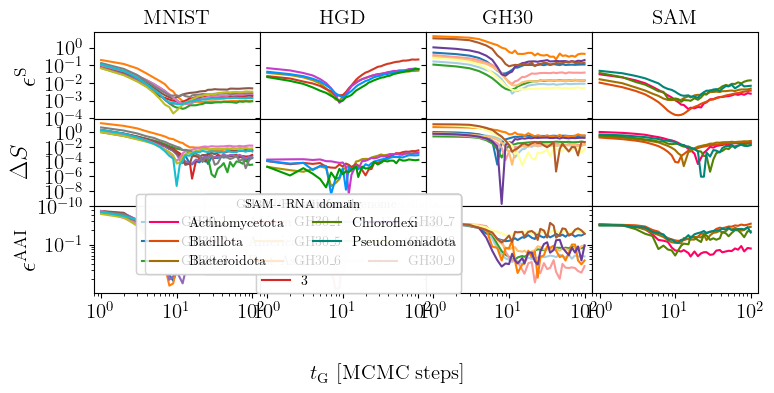

In [160]:
fig = plt.figure(dpi=100, figsize=(8, 4))
gs = fig.add_gridspec(3, 4, hspace=0, wspace=0)
(ax_spectra1, ax_spectra2, ax_spectra3, ax_spectra4), (ax_entropy1, ax_entropy2, ax_entropy3, ax_entropy4), (ax_AAI1, ax_AAI2, ax_AAI3, ax_AAI4) = gs.subplots(sharex='col', sharey='row')

# spectra
data_MNIST = h5py.File('./results/FeF_scores/FeF_scores-MNIST/score_spectra.h5', 'r')
data_DNA = h5py.File('./results/FeF_scores/FeF_scores-DNA/score_spectra.h5', 'r')
data_GH30 = h5py.File('./results/FeF_scores/FeF_scores-GH30/score_spectra.h5', 'r')
data_SAM = h5py.File('./results/FeF_scores/FeF_scores-SAM-Nh100-train/score_spectra.h5', 'r')

n_labels = len(data_MNIST.keys())
colors = cm.get_cmap('tab10', n_labels)
colors_MNIST = {lab : to_hex(colors(i)) for i, lab in enumerate(data_MNIST.keys())}
n_labels = len(data_DNA.keys())
main_colors = ['#0094FF', '#009A00', '#C43CC8', '#D03A24', '#A89400'] # Blue, Green, Violet, Red, Yellow
all_cont = ['European', 'South Asian', 'East Asian', 'American', 'African']
colors_DNA = {cont : color for cont, color in zip(all_cont, main_colors)}
n_labels = len(data_GH30.keys())
colors = cm.get_cmap('Paired', n_labels)
colors_GH30 = {lab : to_hex(colors(i)) for i, lab in enumerate(data_GH30.keys())}
n_labels = len(data_SAM.keys())
main_colors = ['#FF0064', '#DE4C08', '#A07100', '#538200', '#008579']
SAM_labels = np.array(list(data_SAM.keys()))
colors_SAM = {lab : col for lab, col in zip(SAM_labels, main_colors)}

## MNIST
for label in data_MNIST.keys():
    ax_spectra1.plot(record_times, data_MNIST[label][()], color=colors_MNIST[label], label=label)
    
## DNA
for label in data_DNA.keys():
    ax_spectra2.plot(record_times, data_DNA[label][()], color=colors_DNA[label], label=label)
    

## GH30
for label in data_GH30.keys():
    ax_spectra3.plot(record_times, data_GH30[label][()], color=colors_GH30[label], label=label)

## GH30
for label in data_SAM.keys():
    ax_spectra4.plot(record_times, data_SAM[label][()], color=colors_SAM[label], label=label)

data_MNIST.close()
data_DNA.close()
data_GH30.close()
data_SAM.close()

#######################################################################################

# entropy
data_MNIST = h5py.File('./results/FeF_scores/FeF_scores-MNIST/score_entropy.h5', 'r')
data_DNA = h5py.File('./results/FeF_scores/FeF_scores-DNA/score_entropy.h5', 'r')
data_GH30 = h5py.File('./results/FeF_scores/FeF_scores-GH30/score_entropy.h5', 'r')
data_SAM = h5py.File('./results/FeF_scores/FeF_scores-SAM-Nh100-train/score_entropy.h5')

## MNIST
for label in data_MNIST.keys():
    ax_entropy1.plot(record_times, data_MNIST[label][()]**2 + 2e-10, color=colors_MNIST[label])
    
## DNA
for label in data_DNA.keys():
    ax_entropy2.plot(record_times, data_DNA[label][()]**2 + 2e-10, color=colors_DNA[label])

## GH30
for label in data_GH30.keys():
    ax_entropy3.plot(record_times, data_GH30[label][()]**2 + 2e-10, color=colors_GH30[label])

## SAM
for label in data_SAM.keys():
    ax_entropy4.plot(record_times, data_SAM[label][()]**2 + 2e-10, color=colors_SAM[label])
    

data_MNIST.close()
data_DNA.close()
data_GH30.close()
data_SAM.close()

#######################################################################################

# AAI
data_MNIST = h5py.File('./results/FeF_scores/FeF_scores-MNIST/score_AAI.h5', 'r')
data_DNA = h5py.File('./results/FeF_scores/FeF_scores-DNA/score_AAI.h5', 'r')
data_GH30 = h5py.File('./results/FeF_scores/FeF_scores-GH30/score_AAI.h5', 'r')
data_SAM = h5py.File('./results/FeF_scores/FeF_scores-SAM-Nh100-train/score_AAI.h5', 'r')

## MNIST
for label in data_MNIST.keys():
    ax_AAI1.plot(record_times, data_MNIST[label][()], color=colors_MNIST[label])
    
## DNA
for label in data_DNA.keys():
    ax_AAI2.plot(record_times, data_DNA[label][()], color=colors_DNA[label])
    
## GH30
for label in data_GH30.keys():
    ax_AAI3.plot(record_times, data_GH30[label][()], color=colors_GH30[label])
    
## SAM
for label in data_SAM.keys():
    ax_AAI4.plot(record_times, data_SAM[label][()], color=colors_SAM[label])

data_MNIST.close()
data_DNA.close()
data_GH30.close()
data_SAM.close()

#######################################################################################

ax_spectra1.set_xscale('log')
ax_spectra1.set_yscale('log')
#ax_spectra1.set_ylim(1e-4)
ax_spectra1.set_ylabel(r'$\epsilon^{\mathrm{S}}$', size=18)
ax_spectra1.set_title('MNIST', size=15)
ax_spectra2.set_title('HGD', size=15)
ax_spectra3.set_title('GH30', size=15)
ax_spectra4.set_title('SAM', size=15)
ax_spectra2.set_xscale('log')
ax_spectra3.set_xscale('log')
ax_spectra4.set_xscale('log')

ax_entropy1.set_yscale('log')
ax_entropy1.set_ylim(1e-10)
ax_entropy1.set_ylabel(r'$\Delta S$', size=18)
#ax_entropy1.axhline(y=0., ls='dashed', color='black', alpha=0.5)
#ax_entropy2.axhline(y=0., ls='dashed', color='black', alpha=0.5)
#ax_entropy3.axhline(y=0., ls='dashed', color='black', alpha=0.5)

ax_AAI1.set_yscale('log')
#ax_AAI1.set_ylim(1e-2)
ax_AAI1.set_ylabel(r'$\epsilon^{\mathrm{AAI}}$', size=18)
fig.supxlabel(r'$t_{\mathrm{G}}$ [MCMC steps]', size=15)

for ax in fig.get_axes():
    ax.label_outer()

ax_spectra1.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
ax_entropy1.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
ax_AAI1.yaxis.set_major_locator(LogLocator(base=10.0, numticks=20))

h_MNIST, l_MNIST = ax_spectra1.get_legend_handles_labels()
h_DNA, l_DNA = ax_spectra2.get_legend_handles_labels()
h_GH30, l_GH30 = ax_spectra3.get_legend_handles_labels()
h_SAM, l_SAM = ax_spectra4.get_legend_handles_labels()
fig.gca().add_artist(fig.legend(h_MNIST, l_MNIST, ncol=3, bbox_to_anchor=(0.6,0.5), fontsize=10, title='MNIST - Handwritten digits'))
fig.gca().add_artist(fig.legend(h_DNA, l_DNA, ncol=2, bbox_to_anchor=(0.6,0.5), fontsize=10, title='HGD - Human genome'))
fig.gca().add_artist(fig.legend(h_GH30, [l.replace('_', '\_') for l in l_GH30], ncol=3, bbox_to_anchor=(0.6,0.5), fontsize=10, title='GH30 - Protein family'))
fig.gca().add_artist(fig.legend(h_SAM, [l.replace('_', '\_') for l in l_SAM], ncol=2, bbox_to_anchor=(0.6,0.5), fontsize=10, title='SAM - RNA domain'))
fig.tight_layout()
fig.savefig('/home/lorenzo.rosset/Documents/drawings/FeF/svg/scores_vs_time_v3.svg')


Plot the legend

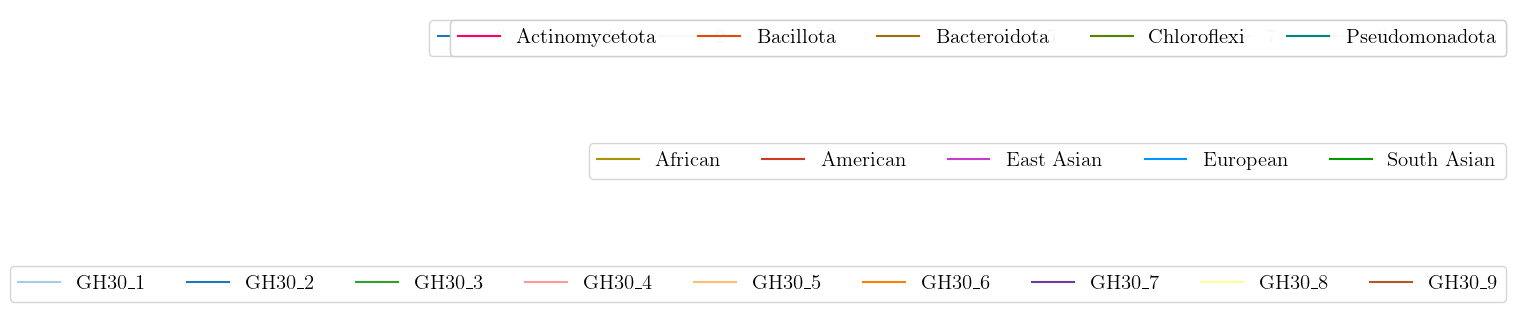

In [49]:
h_MNIST, l_MNIST = ax_spectra1.get_legend_handles_labels()
h_DNA, l_DNA = ax_spectra2.get_legend_handles_labels()
h_GH30, l_GH30 = ax_spectra3.get_legend_handles_labels()
h_SAM, l_SAM = ax_spectra4.get_legend_handles_labels()

fig = plt.figure(dpi=100, figsize=(15,4))
ax = plt.subplot(111)
ax.axis('off')
plt.gca().add_artist(plt.legend(h_MNIST, l_MNIST, loc='upper right', ncol=10))
plt.gca().add_artist(plt.legend(h_DNA, l_DNA, loc='center right', ncol=5))
plt.gca().add_artist(plt.legend(h_GH30, [l.replace('_', '\_') for l in l_GH30], loc='lower right', ncol=9))
plt.gca().add_artist(plt.legend(h_SAM, [l.replace('_', '\_') for l in l_SAM], loc='best', ncol=5))
plt.savefig('/home/lorenzo.rosset/Desktop/legend.svg')

Measure the number of samples for each category

In [3]:
f = h5py.File('data/MNIST.h5', 'r')
data_type = 'train'

labels = f[data_type + '_labels'].asstr()[()]
lab, counts = np.unique(labels, return_counts=True)
print('label -> count')
for l, c in zip(lab, counts):
    print(f'{l} -> {c}')
f.close()

label -> count
0 -> 1022
1 -> 1078
2 -> 1046
3 -> 1031
4 -> 965
5 -> 916
6 -> 972
7 -> 1042
8 -> 977
9 -> 951


In [4]:
f = h5py.File('data/DNA.h5', 'r')
data_type = 'train'

labels = f[data_type + '_labels'].asstr()[()]
print(f'total length: {len(labels)}\n')
lab, counts = np.unique(labels, return_counts=True)
print('label -> count')
for l, c in zip(lab, counts):
    print(f'{l} -> {c}')
f.close()

total length: 4507

label -> count
African -> 1184
American -> 622
East Asian -> 912
European -> 910
South Asian -> 879


In [5]:
f = h5py.File('data/GH30_annotated.h5', 'r')
data_type = 'test'

labels = f[data_type + '_labels'].asstr()[()]
lab, counts = np.unique(labels, return_counts=True)
print('label -> count')
for l, c in zip(lab, counts):
    print(f'{l} -> {c}')
f.close()

label -> count
GH30_1 -> 221
GH30_2 -> 71
GH30_3 -> 260
GH30_4 -> 67
GH30_5 -> 108
GH30_6 -> 9
GH30_7 -> 22
GH30_8 -> 202
GH30_9 -> 15


In [155]:
f = h5py.File('data/SAM.h5', 'r')
data_type = 'train'

labels = f[data_type + '_labels'].asstr()[()]
lab, counts = np.unique(labels, return_counts=True)
print('label -> count')
for l, c in zip(lab, counts):
    print(f'{l} -> {c}')
f.close()

label -> count
Actinomycetota -> 549
Bacillota -> 3159
Bacteroidota -> 747
Chloroflexi -> 120
Pseudomonadota -> 158


## PCAs with histograms of generated data

In [148]:
def plot_scatter_labels(ax, proj1, proj2):    
    for lab in unique_labels:
        idx = np.where(lab == labels_data)[0]
        ax.scatter(data_proj[idx, proj1], data_proj[idx, proj2], color=colors_dict[lab], s=50, zorder=0, alpha=0.5)
        idx = np.where(label2num[lab] == targets.cpu().numpy())[0]
        ax.scatter(gen_data_proj[idx, proj1], gen_data_proj[idx, proj2], color=colors_dict[lab], label=lab, s=20, zorder=2, edgecolor='black', marker='o', alpha=1, linewidth=0.4)
    ax.set_xlabel(f'{proj1+1} PC')
    ax.set_ylabel(f'{proj2+1} PC')
    
def plot_hist(ax, proj, orientation='vertical'):    
    ax.hist(data_proj[:, proj], bins=50, color='black', histtype='step', label='data', zorder=1, density=True, orientation=orientation)
    ax.hist(gen_data_proj[:, proj], bins=50, color='#846DCE', label='generated', zorder=0, alpha=0.8, density=True, orientation=orientation)
    ax.set_xlabel(fr'$m_{proj}$')
    ax.set_ylabel('density')
    ax.axis('off')

### DNA

In [154]:
# to change
RBM = importlib.import_module('BernoulliBernoulliSslRBM').RBM
device = torch.device('cuda:1')
fname_model = 'models/DNA/BernoulliBernoulliSslRBM-2023.6.20.12.3-DNA-ep30000-lr0.01-Nh1024-NGibbs100-mbs4507-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-PCD.h5'
fname_data = 'data/DNA.h5'
data_type = 'train'
n_data = 5000 # take only part of the dataset. Large sequences would otherwise fill the GPU's memory

In [155]:
f_data = h5py.File(fname_data, 'r')
f_model = h5py.File(fname_model, 'r')
all_X_data = np.array(f_data[data_type]).astype(np.float32)
all_labels_data = f_data[data_type + '_labels'].asstr()[()]
all_sublabels_data = f_data[data_type + '_sublabels'].asstr()[()]

X_data = torch.tensor(all_X_data[:n_data], device=device)
labels_data = all_labels_data[:n_data]
sublabels_data = all_sublabels_data[:n_data]
unique_labels = np.unique(labels_data)
unique_sublabels = np.unique(sublabels_data)
leaves_names = f_data[data_type + '_names'].asstr()[:n_data]

label2num = {lab : i for i, lab in enumerate(np.unique(labels_data))}

rbm = RBM(device=device)
alltime = f_model['alltime'][()]
print('All times:\n', alltime)
stamp = input('Select the time stamp: ')
rbm.loadRBM(fname_model, stamp=int(stamp))
stamp = rbm.t_age

All times:
 [    1     2     4     7    13    22    36    61   103   173   290   485
   813  1361  2279  3816  6390 10700 17916 30000]


In [156]:
_, S_data, V_data = torch.svd(X_data - X_data.mean(0))
V_data /= X_data.shape[1]**0.5

data_proj = X_data @ V_data
data_proj = data_proj.cpu().numpy()

In [157]:
main_colors = ['#0094FF', '#009A00', '#C43CC8', '#D03A24', '#A89400'] # Blue, Green, Violet, Red, Yellow
secondary_colors = ['#002CFF', '#0094FF', '#00CEFF', '#58FBDA', '#B0CBD2',                        # 5 blue,
                    '#A005A6', '#C43CC8', '#E861EB', '#FF84FF', '#FFA7FF',                        # 5 violet
                    '#003D00', '#006900', '#009A00', '#00CB00', '#15FF00',                        # 5 green
                    '#A60505', '#D03A24', '#FA5F43', '#FF8463',                                   # 4 red
                    '#382600', '#554900', '#7C6D00', '#A89400', '#D5BC15', '#FFBA4A', '#FFEDCB']  # 7 yellow

all_cont = ['European', 'South Asian', 'East Asian', 'American', 'African']

all_pops =   ['FIN', 'GBR', 'CEU', 'IBS', 'TSI',                  # European
              'CHS', 'CDX', 'CHB', 'JPT', 'KHV',                  # South Asian
              'GIH', 'STU', 'PJL', 'ITU', 'BEB',                  # East Asian
              'PEL', 'MXL', 'CLM', 'PUR',                         # American
              'ACB', 'GWD', 'YRI', 'LWK', 'ESN', 'MSL', 'ASW']    # African


colors_dict = {cont : color for cont, color in zip(all_cont, main_colors)}
subcolors_dict = {population : color for population, color in zip(all_pops, secondary_colors)}
labels_dict = {leaf_name : leaf_label for leaf_name, leaf_label in zip(leaves_names, labels_data)}
sublabels_dict = {leaf_name : leaf_label for leaf_name, leaf_label in zip(leaves_names, sublabels_data)}

In [158]:
it_mcmc = 100000
n_gen = len(X_data)
targets = torch.tensor([label2num[l] for l in labels_data], device=device, dtype=torch.int64)
rand_init = torch.randint(0, 2, size=(len(targets), rbm.Nv), device=device).float()
gen_data, *_ = rbm.conditioned_sampling(rand_init, targets, it_mcmc=it_mcmc)
gen_data_proj = gen_data @ V_data
gen_data_proj = gen_data_proj.cpu().numpy()

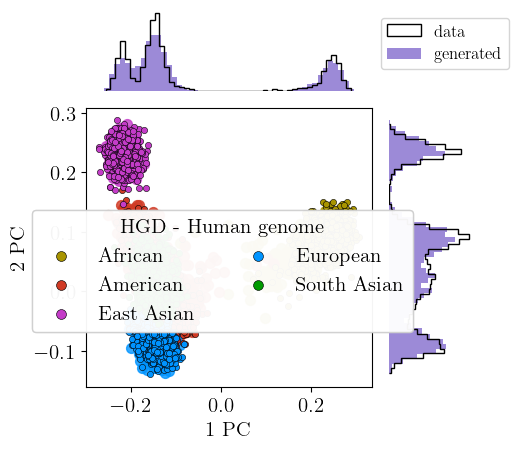

In [161]:
plt.rcParams['legend.title_fontsize'] = 'medium'
fig = plt.figure(dpi=100, figsize=(5,5))
gs = GridSpec(4, 4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_x = fig.add_subplot(gs[0,0:3])
ax_hist_y = fig.add_subplot(gs[1:4, 3])

plot_scatter_labels(ax_scatter, 0, 1)
plot_hist(ax_hist_x, 0)
plot_hist(ax_hist_y, 1, orientation='horizontal')

ax_hist_x.legend(fontsize=12, bbox_to_anchor=(1, 1));
h, l = ax_scatter.get_legend_handles_labels()
lgnd = fig.legend(h, l, ncol=2, bbox_to_anchor=(0.8,0.5), fontsize=15, title='HGD - Human genome')
for handle in lgnd.legendHandles:
    handle._sizes = [50]
fig.gca().add_artist(lgnd)
plt.savefig('/home/lorenzo.rosset/Documents/drawings/FeF/svg/PCA_hist-HGD-PCD.svg')

In [120]:
h[0].set(sizes=[50,])

[None]

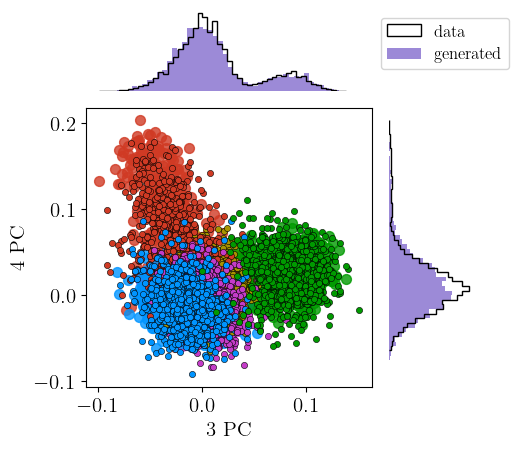

In [95]:
fig = plt.figure(dpi=100, figsize=(5,5))
gs = GridSpec(4, 4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_x = fig.add_subplot(gs[0,0:3])
ax_hist_y = fig.add_subplot(gs[1:4, 3])

plot_scatter_labels(ax_scatter, 2, 3)
plot_hist(ax_hist_x, 2)
plot_hist(ax_hist_y, 3, orientation='horizontal')

ax_hist_x.legend(fontsize=12, bbox_to_anchor=(1, 1));

### MNIST

In [26]:
# to change
RBM = importlib.import_module('BernoulliBernoulliSslRBM').RBM
device = torch.device('cuda:1')
fname_model = 'models/MNIST/BernoulliBernoulliSslRBM-2023.7.6.11.29-MNIST-ep30000-lr0.01-Nh500-NGibbs100-mbs500-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-PCD.h5'
fname_data = 'data/MNIST.h5'
data_type = 'train'
n_data = 5000 # take only part of the dataset. Large sequences would otherwise fill the GPU's memory

In [27]:
f_data = h5py.File(fname_data, 'r')
f_model = h5py.File(fname_model, 'r')
all_X_data = np.array(f_data[data_type]).astype(np.float32)
all_labels_data = f_data[data_type + '_labels'].asstr()[()]

X_data = torch.tensor(all_X_data[:n_data], device=device)
labels_data = all_labels_data[:n_data]
unique_labels = np.unique(labels_data)
leaves_names = f_data[data_type + '_names'].asstr()[:n_data]

label2num = {lab : i for i, lab in enumerate(np.unique(labels_data))}

rbm = RBM(device=device)
alltime = f_model['alltime'][()]
print('All times:\n', alltime)
stamp = input('Select the time stamp: ')
rbm.loadRBM(fname_model, stamp=int(stamp))
stamp = rbm.t_age

All times:
 [    1     2     4     7    13    22    36    61   103   173   290   485
   813  1361  2279  3816  6390 10700 17916 30000]


In [28]:
_, S_data, V_data = torch.svd(X_data - X_data.mean(0))
V_data /= X_data.shape[1]**0.5

data_proj = X_data @ V_data
data_proj = data_proj.cpu().numpy()

In [29]:
it_mcmc = 10000
n_gen = len(X_data)
targets = torch.tensor([label2num[l] for l in labels_data], device=device, dtype=torch.int64)
rand_init = torch.randint(0, 2, size=(len(targets), rbm.Nv), device=device).float()
gen_data, *_ = rbm.conditioned_sampling(rand_init, targets, it_mcmc=it_mcmc)
gen_data_proj = gen_data @ V_data
gen_data_proj = gen_data_proj.cpu().numpy()

In [30]:
colors = cm.get_cmap('tab10', len(unique_labels))
colors_dict = {lab : colors(i) for i, lab in enumerate(unique_labels)}

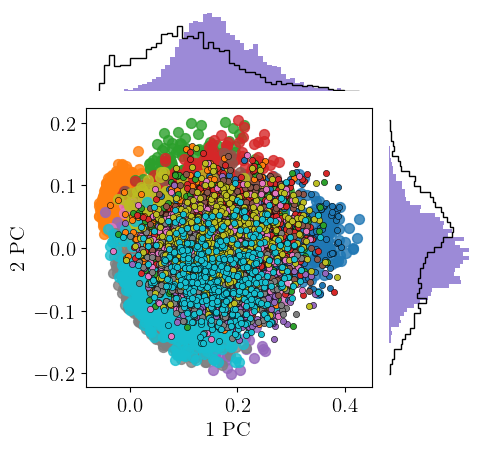

In [31]:
fig = plt.figure(dpi=100, figsize=(5,5))
gs = GridSpec(4, 4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_x = fig.add_subplot(gs[0,0:3])
ax_hist_y = fig.add_subplot(gs[1:4, 3])

plot_scatter_labels(ax_scatter, 0, 1)
plot_hist(ax_hist_x, 0)
plot_hist(ax_hist_y, 1, orientation='horizontal')

#ax_hist_x.legend(fontsize=12, bbox_to_anchor=(1, 1));
#h, l = ax_scatter.get_legend_handles_labels()
#lgnd = fig.legend(h, l, ncol=3, bbox_to_anchor=(0.7,0.5), fontsize=15, title='MNIST - Handwritten digits')
#for handle in lgnd.legendHandles:
#    handle._sizes = [50]
#fig.gca().add_artist(lgnd)
#plt.savefig('/home/lorenzo.rosset/Documents/drawings/FeF/PCA_hist-MNIST-PCD.svg')

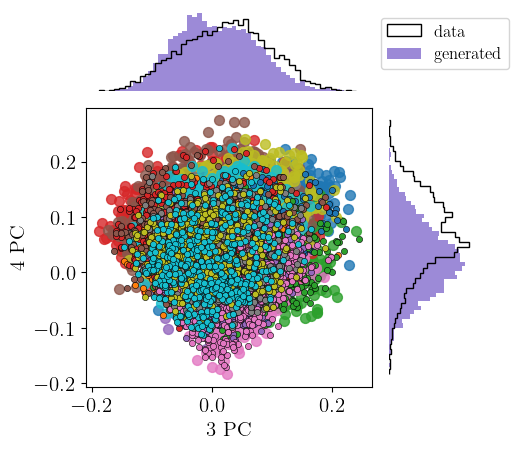

In [23]:
fig = plt.figure(dpi=100, figsize=(5,5))
gs = GridSpec(4, 4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_x = fig.add_subplot(gs[0,0:3])
ax_hist_y = fig.add_subplot(gs[1:4, 3])

plot_scatter_labels(ax_scatter, 2, 3)
plot_hist(ax_hist_x, 2)
plot_hist(ax_hist_y, 3, orientation='horizontal')

ax_hist_x.legend(fontsize=12, bbox_to_anchor=(1, 1));

### GH30

In [186]:
# to change
RBM = importlib.import_module('PottsBernoulliSslRBM').RBM
device = torch.device('cuda:0')
fname_model = 'models/GH30_annotated/PottsBernoulliSslRBM-2023.5.4.23.8-GH30_annotated-ep30000-lr0.01-Nh1024-NGibbs10-mbs1961-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-Rdm.h5'
fname_data = 'data/GH30_annotated.h5'
data_type = 'test'
n_data = 3000 # take only part of the dataset. Large sequences would otherwise fill the GPU's memory

In [187]:
f_data = h5py.File(fname_data, 'r')
f_model = h5py.File(fname_model, 'r')
all_X_data = np.array(f_data[data_type]).astype(np.float32)
all_labels_data = f_data[data_type + '_labels'].asstr()[()]

X_data = torch.tensor(all_X_data[:n_data], device=device, dtype=torch.int64)
labels_data = all_labels_data[:n_data]
unique_labels = np.unique(labels_data)
leaves_names = f_data[data_type + '_names'].asstr()[:n_data]

label2num = {lab : i for i, lab in enumerate(np.unique(labels_data))}

rbm = RBM(device=device)
alltime = f_model['alltime'][()]
print('All times:\n', alltime)
stamp = input('Select the time stamp: ')
rbm.loadRBM(fname_model, stamp=int(stamp))
stamp = rbm.t_age

All times:
 [    1     2     3     4     5     6     7     9    11    14    17    22
    27    33    40    50    61    75    93   114   140   173   212   261
   321   395   485   596   733   901  1107  1361  1673  2056  2527  3105
  3816  4690  5764  7084  8706 10700 13150 16161 19862 24410 30000]


In [188]:
X_data_oh = one_hot(X_data).reshape(X_data.shape[0], -1).float()
_, S_data, V_data = torch.svd(X_data_oh - X_data_oh.mean(0))
V_data /= X_data.shape[1]**0.5

data_proj = X_data_oh @ V_data
data_proj = data_proj.cpu().numpy()

In [189]:
it_mcmc = 10
n_gen = len(X_data)
targets = torch.tensor([label2num[l] for l in labels_data], device=device, dtype=torch.int64)
rand_init = torch.randint(0, rbm.num_states, size=(len(targets), rbm.Nv), device=device).type(torch.int64)
gen_data, *_ = rbm.conditioned_sampling(rand_init, targets, it_mcmc=it_mcmc)
gen_data_oh = one_hot(gen_data).reshape(gen_data.shape[0], -1).float()
gen_data_proj = gen_data_oh @ V_data
gen_data_proj = gen_data_proj.cpu().numpy()

In [190]:
colors = cm.get_cmap('Paired', len(unique_labels))
colors_dict = {lab : colors(i) for i, lab in enumerate(unique_labels)}

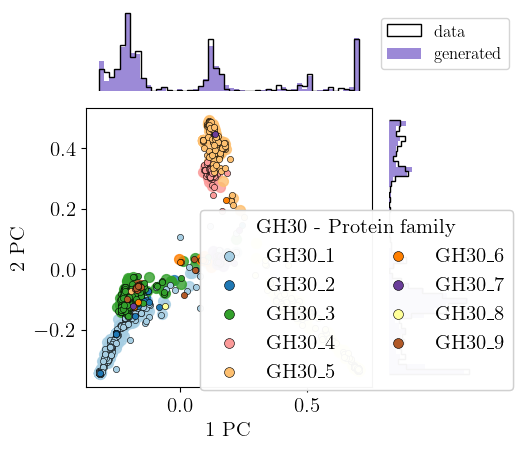

In [192]:
fig = plt.figure(dpi=100, figsize=(5,5))
gs = GridSpec(4, 4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_x = fig.add_subplot(gs[0,0:3])
ax_hist_y = fig.add_subplot(gs[1:4, 3])

plot_scatter_labels(ax_scatter, 0, 1)
plot_hist(ax_hist_x, 0)
plot_hist(ax_hist_y, 1, orientation='horizontal')

ax_hist_x.legend(fontsize=12, bbox_to_anchor=(1, 1));

ax_hist_x.legend(fontsize=12, bbox_to_anchor=(1, 1));
h, l = ax_scatter.get_legend_handles_labels()
lgnd = fig.legend(h, [ll.replace('_', '\_') for ll in l], ncol=2, bbox_to_anchor=(1,0.5), fontsize=15, title='GH30 - Protein family')
for handle in lgnd.legendHandles:
    handle._sizes = [50]
fig.gca().add_artist(lgnd)
plt.savefig('/home/lorenzo.rosset/Documents/drawings/FeF/svg/PCA_hist-GH30-Rdm.svg')

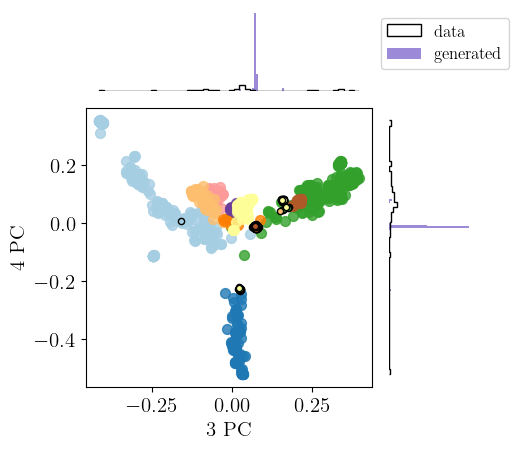

In [135]:
fig = plt.figure(dpi=100, figsize=(5,5))
gs = GridSpec(4, 4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_x = fig.add_subplot(gs[0,0:3])
ax_hist_y = fig.add_subplot(gs[1:4, 3])

plot_scatter_labels(ax_scatter, 2, 3)
plot_hist(ax_hist_x, 2)
plot_hist(ax_hist_y, 3, orientation='horizontal')

ax_hist_x.legend(fontsize=12, bbox_to_anchor=(1, 1));

### SAM

In [151]:
# to change
RBM = importlib.import_module('PottsBernoulliSslRBM').RBM
device = torch.device('cuda:1')
fname_model = 'models/SAM/PottsBernoulliSslRBM-2023.7.5.14.19-SAM-ep30000-lr0.01-Nh100-NGibbs10-mbs1000-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-Rdm.h5'
fname_data = 'data/SAM.h5'
data_type = 'train'
n_data = 3000 # take only part of the dataset. Large sequences would otherwise fill the GPU's memory

In [152]:
f_data = h5py.File(fname_data, 'r')
f_model = h5py.File(fname_model, 'r')
all_X_data = np.array(f_data[data_type]).astype(np.float32)
all_labels_data = f_data[data_type + '_labels'].asstr()[()]

X_data = torch.tensor(all_X_data[:n_data], device=device, dtype=torch.int64)
labels_data = all_labels_data[:n_data]
unique_labels = np.unique(labels_data)
leaves_names = f_data[data_type + '_names'].asstr()[:n_data]

label2num = {lab : i for i, lab in enumerate(np.unique(labels_data))}

rbm = RBM(device=device)
alltime = f_model['alltime'][()]
print('All times:\n', alltime)
stamp = input('Select the time stamp: ')
rbm.loadRBM(fname_model, stamp=int(stamp))
stamp = rbm.t_age

All times:
 [    1     2     4     7    13    22    36    61   103   173   290   485
   813  1361  2279  3816  6390 10700 17916 30000]


In [153]:
X_data_oh = one_hot(X_data).reshape(X_data.shape[0], -1).float()
_, S_data, V_data = torch.svd(X_data_oh - X_data_oh.mean(0))
V_data /= X_data.shape[1]**0.5

data_proj = X_data_oh @ V_data
data_proj = data_proj.cpu().numpy()

In [154]:
it_mcmc = 10
n_gen = len(X_data)
targets = torch.tensor([label2num[l] for l in labels_data], device=device, dtype=torch.int64)
rand_init = torch.randint(0, rbm.num_states, size=(len(targets), rbm.Nv), device=device).type(torch.int64)
gen_data, *_ = rbm.conditioned_sampling(rand_init, targets, it_mcmc=it_mcmc)
gen_data_oh = one_hot(gen_data).reshape(gen_data.shape[0], -1).float()
gen_data_proj = gen_data_oh @ V_data
gen_data_proj = gen_data_proj.cpu().numpy()

In [155]:
colors = ['#FF0064', '#DE4C08', '#A07100', '#538200', '#008579']
colors_dict = {lab : colors[i] for i, lab in enumerate(unique_labels)}

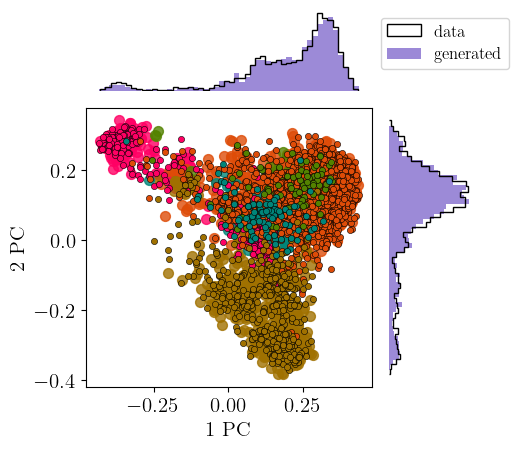

In [156]:
fig = plt.figure(dpi=100, figsize=(5,5))
gs = GridSpec(4, 4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_x = fig.add_subplot(gs[0,0:3])
ax_hist_y = fig.add_subplot(gs[1:4, 3])

plot_scatter_labels(ax_scatter, 0, 1)
plot_hist(ax_hist_x, 0)
plot_hist(ax_hist_y, 1, orientation='horizontal')

ax_hist_x.legend(fontsize=12, bbox_to_anchor=(1, 1));
h, l = ax_scatter.get_legend_handles_labels()
#lgnd = fig.legend(h, [ll.replace('_', '\_') for ll in l], ncol=2, bbox_to_anchor=(1,0.5), fontsize=15, title='SAM - RNA domain')
for handle in lgnd.legendHandles:
    handle._sizes = [50]
#fig.gca().add_artist(lgnd)
plt.savefig('/home/lorenzo.rosset/Documents/drawings/FeF/svg/PCA_hist-SAM-Rdm-Nh100.svg')

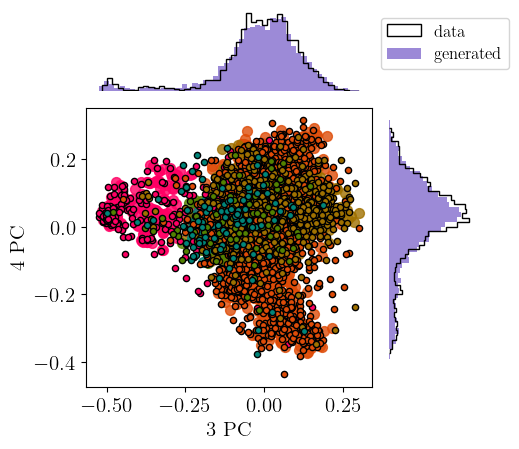

In [120]:
fig = plt.figure(dpi=100, figsize=(5,5))
gs = GridSpec(4, 4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_x = fig.add_subplot(gs[0,0:3])
ax_hist_y = fig.add_subplot(gs[1:4, 3])

plot_scatter_labels(ax_scatter, 2, 3)
plot_hist(ax_hist_x, 2)
plot_hist(ax_hist_y, 3, orientation='horizontal')

ax_hist_x.legend(fontsize=12, bbox_to_anchor=(1, 1));

## Comparing scores for different models

In [24]:
scores_repo_PCD = '/home/lorenzo.rosset/RBM-Proteins/results/output_sampling/BernoulliBernoulliSslRBM-2023.7.6.11.29-MNIST-ep30000-lr0.01-Nh500-NGibbs100-mbs500-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-PCD/scores'
scores_repo_Rdm = '/home/lorenzo.rosset/RBM-Proteins/results/output_sampling/BernoulliBernoulliSslRBM-2023.7.6.11.31-MNIST-ep30000-lr0.01-Nh500-NGibbs10-mbs500-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-Rdm/scores'
UpdByEpoch = 2

# PCD
f = File(scores_repo_PCD + '/spectra_score.h5', 'r')
record_times_PCD = f['record_times'][()]
spectra_score_PCD = {}
for t_age in f.keys():
    if t_age != 'record_times':
        spectra_score_PCD[t_age] = f[t_age][()]

f = File(scores_repo_PCD + '/entropy_score.h5', 'r')
entropy_score_PCD = {}
for t_age in f.keys():
    if t_age != 'record_times':
        entropy_score_PCD[t_age] = f[t_age][()]**2

f = File(scores_repo_PCD + '/AAI_score.h5', 'r')
AAI_score_PCD = {}
for t_age in f.keys():
    if t_age != 'record_times':
        AAI_score_PCD[t_age] = f[t_age][()]
        

# Rdm
f = File(scores_repo_Rdm + '/spectra_score.h5', 'r')
record_times_Rdm = f['record_times'][()]
spectra_score_Rdm = {}
for t_age in f.keys():
    if t_age != 'record_times':
        spectra_score_Rdm[t_age] = f[t_age][()]

f = File(scores_repo_Rdm + '/entropy_score.h5', 'r')
entropy_score_Rdm = {}
for t_age in f.keys():
    if t_age != 'record_times':
        entropy_score_Rdm[t_age] = f[t_age][()]**2

f = File(scores_repo_Rdm + '/AAI_score.h5', 'r')
AAI_score_Rdm = {}
for t_age in f.keys():
    if t_age != 'record_times':
        AAI_score_Rdm[t_age] = f[t_age][()]

f.close()


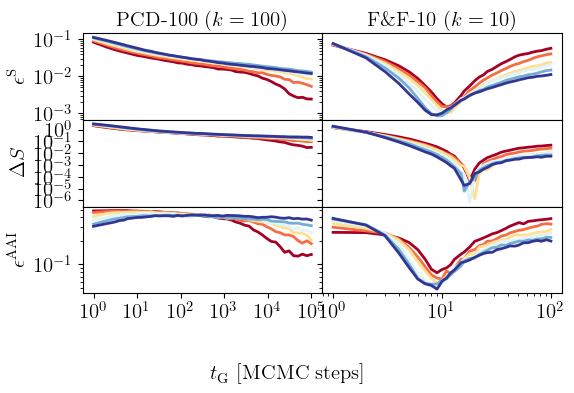

In [25]:
t_ages = np.sort(np.array(list(spectra_score_PCD.keys()), dtype=int))
n_curves = len(t_ages)
colors = cm.get_cmap('RdYlBu', n_curves)

fig = plt.figure(dpi=100, figsize=(6, 4))
gs = fig.add_gridspec(3, 2, hspace=0, wspace=0)
(ax_spectra_PCD, ax_spectra_Rdm), (ax_entropy_PCD, ax_entropy_Rdm), (ax_AAI_PCD, ax_AAI_Rdm) = gs.subplots(sharex='col', sharey='row')

# spectra PCD
ax_spectra_PCD.set_yscale('log')
ax_spectra_PCD.set_ylabel(r'$\epsilon^{\mathrm{S}}$')
ax_spectra_PCD.set_title(r'PCD-100 $(k=100)$', size=15)

for i, t_age in enumerate(t_ages):
    ax_spectra_PCD.plot(record_times_PCD, spectra_score_PCD[str(t_age)], color=colors(i), lw=2, label=r'$t_{\mathrm{age}}=$' + str(t_age * UpdByEpoch))
    
# entropy PCD
ax_entropy_PCD.set_yscale('log')
ax_entropy_PCD.set_ylabel(r'$\Delta S$')
ax_entropy_PCD.yaxis.set_major_locator(LogLocator(base=10.0, numticks=20))
    
for i, t_age in enumerate(t_ages):
    ax_entropy_PCD.plot(record_times_PCD, entropy_score_PCD[str(t_age)], color=colors(i), lw=2, label=r'$t_{\mathrm{age}}=$' + str(t_age * UpdByEpoch))
    
# AAI PCD
ax_AAI_PCD.set_yscale('log')
ax_AAI_PCD.set_xscale('log')
ax_AAI_PCD.xaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
ax_AAI_PCD.set_ylabel(r'$\epsilon^{\mathrm{AAI}}$')
    
for i, t_age in enumerate(t_ages):
    ax_AAI_PCD.plot(record_times_PCD, AAI_score_PCD[str(t_age)], color=colors(i), lw=2, label=r'$t_{\mathrm{age}}=$' + str(t_age * UpdByEpoch))

t_ages = np.sort(np.array(list(spectra_score_Rdm.keys()), dtype=int))
n_curves = len(t_ages)
colors = cm.get_cmap('RdYlBu', n_curves)

# spectra Rdm
ax_spectra_Rdm.set_title(r'F\&F-10 $(k=10)$', size=15)
for i, t_age in enumerate(t_ages):
    ax_spectra_Rdm.plot(record_times_Rdm, spectra_score_Rdm[str(t_age)], color=colors(i), lw=2, label=r'$t_{\mathrm{age}}=$' + str(t_age * UpdByEpoch))

# entropy Rdm
for i, t_age in enumerate(t_ages):
    ax_entropy_Rdm.plot(record_times_Rdm, entropy_score_Rdm[str(t_age)], color=colors(i), lw=2, label=r'$t_{\mathrm{age}}=$' + str(t_age * UpdByEpoch))

# AAI Rdm
ax_AAI_Rdm.set_xscale('log')
for i, t_age in enumerate(t_ages):
    ax_AAI_Rdm.plot(record_times_Rdm, AAI_score_Rdm[str(t_age)], color=colors(i), lw=2, label=r'$t_{\mathrm{age}}=$' + str(t_age * UpdByEpoch))

fig.supxlabel(r'$t_{\mathrm{G}}$ [MCMC steps]', size=15)
for ax in fig.get_axes():
    ax.label_outer()

fig.tight_layout()

#fig.savefig('/home/lorenzo.rosset/Documents/drawings/FeF/svg/scores_comparison-MNIST.svg')

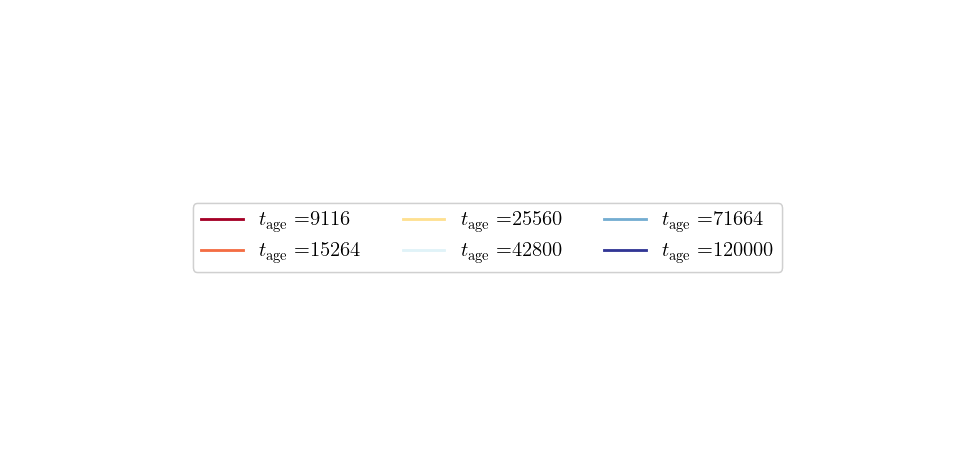

In [123]:
# plot the legend
h, l = ax_spectra_PCD.get_legend_handles_labels()

fig = plt.figure(dpi=100, figsize=(10,5))
ax = plt.subplot(111)
ax.axis('off')
plt.gca().add_artist(plt.legend(h, l, loc='center', ncol=3))
plt.tight_layout()

plt.savefig('/home/lorenzo.rosset/Documents/drawings/FeF/svg/legend_SAM.svg')

In [157]:
fname_model = 'models/SAM/PottsBernoulliSslRBM-2023.6.26.17.41-SAM-ep30000-lr0.01-Nh1024-NGibbs100-mbs1000-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-PCD.h5'
RBM = importlib.import_module('PottsBernoulliSslRBM').RBM
rbm = RBM()
rbm.loadRBM(fname_model)

In [158]:
print(rbm.print_log())


        date: 2023/06/26 17:41
        model: PottsBernoulliSslRBM
        dataset: SAM.h5
        training mode: PCD
        Nv: 108  Nh: 1024 epochs: 30000 lr: 0.01 lr_labels: 0.01 gibbs_steps: 100 batch_size: 1000 num_pcd: 1000 L1_reg: 0.0 L2_reg: 0.0
        Gradient updates per epoch: 4
        training time: 10h11m2s
        seed: 0
        


## Label prediction

In [126]:
#fname_models = {
#    'MNIST' : 'models/MNIST/BernoulliBernoulliSslRBM-2023.5.11.17.38-MNIST-ep100000-lr0.01-Nh1000-NGibbs10-mbs500-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-Rdm.h5',
#    'HGD' : 'models/DNA/BernoulliBernoulliSslRBM-2023.5.24.10.44-DNA-ep30000-lr0.01-Nh1024-NGibbs10-mbs4507-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-Rdm.h5',
#    'GH30' : 'models/GH30_annotated/PottsBernoulliSslRBM-2023.5.4.23.8-GH30_annotated-ep30000-lr0.01-Nh1024-NGibbs10-mbs1961-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-Rdm.h5',
#    'SAM' : 'models/SAM/PottsBernoulliSslRBM-2023.6.26.17.44-SAM-ep30000-lr0.01-Nh1024-NGibbs10-mbs1000-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-Rdm.h5'
#}

fname_models = {
    'MNIST' : 'models/MNIST/BernoulliBernoulliSslRBM-2023.5.11.17.38-MNIST-ep100000-lr0.01-Nh1000-NGibbs10-mbs500-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-Rdm.h5',
    'HGD' : 'models/DNA/BernoulliBernoulliSslRBM-2023.5.24.10.44-DNA-ep30000-lr0.01-Nh1024-NGibbs10-mbs4507-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-Rdm.h5',
    'GH30' : 'models/GH30_annotated/PottsBernoulliSslRBM-2023.5.4.23.8-GH30_annotated-ep30000-lr0.01-Nh1024-NGibbs10-mbs1961-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-Rdm.h5',
    'SAM' : 'models/SAM/PottsBernoulliSslRBM-2023.7.5.14.19-SAM-ep30000-lr0.01-Nh100-NGibbs10-mbs1000-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-Rdm.h5'
}

device = torch.device('cuda:1')
alltimes_Rdm = {'MNIST' : [], 'HGD' : [], 'GH30' : [], 'SAM' : []}
acc_lists_Rdm = {'MNIST' : [], 'HGD' : [], 'GH30' : [], 'SAM' : []}

data_set = 'test'
it_mcmc = 10

# MNIST
dataset_name = 'MNIST'
fname_data = 'data/MNIST.h5'
data_type = torch.float32
RBM = importlib.import_module('BernoulliBernoulliSslRBM').RBM

f = h5py.File(fname_data, 'r')
X_data = torch.tensor(f[data_set][()], device=device, dtype=data_type)
labels_data_string = f[data_set + '_labels'].asstr()[()]
lab2num = {l : i for i, l in enumerate(np.unique(labels_data_string))}
labels_data = torch.tensor([lab2num[l] for l in labels_data_string], device=device, dtype=torch.int64)
rbm = RBM(device=device)
rbm.loadRBM(fname_models[dataset_name])
L_init = torch.randint(0, rbm.num_categ, size=(X_data.shape[0],), device=device).type(torch.int64)
alltime = rbm.list_save_rbm
for t in alltime[alltime < 35000]:
    rbm.loadRBM(fname_models[dataset_name], stamp=t)
    predictions = rbm.predict(X_data, L_init, it_mcmc=it_mcmc).argmax(-1)
    accuracy = ((labels_data == predictions).sum() / len(labels_data)).cpu().numpy()
    acc_lists_Rdm[dataset_name].append(accuracy)
    alltimes_Rdm[dataset_name].append(t * rbm.UpdByEpoch)
    
# HGD
dataset_name = 'HGD'
fname_data = 'data/DNA.h5'
data_type = torch.float32
RBM = importlib.import_module('BernoulliBernoulliSslRBM').RBM

f = h5py.File(fname_data, 'r')
X_data = torch.tensor(f[data_set][()], device=device, dtype=data_type)
labels_data_string = f[data_set + '_labels'].asstr()[()]
lab2num = {l : i for i, l in enumerate(np.unique(labels_data_string))}
labels_data = torch.tensor([lab2num[l] for l in labels_data_string], device=device, dtype=torch.int64)
rbm = RBM(device=device)
rbm.loadRBM(fname_models[dataset_name])
L_init = torch.randint(0, rbm.num_categ, size=(X_data.shape[0],), device=device).type(torch.int64)
alltime = rbm.list_save_rbm
for t in alltime[alltime < 35000]:
    rbm.loadRBM(fname_models[dataset_name], stamp=t)
    predictions = rbm.predict(X_data, L_init, it_mcmc=it_mcmc).argmax(-1)
    accuracy = ((labels_data == predictions).sum() / len(labels_data)).cpu().numpy()
    acc_lists_Rdm[dataset_name].append(accuracy)
    alltimes_Rdm[dataset_name].append(t * rbm.UpdByEpoch)
    
# GH30
dataset_name = 'GH30'
fname_data = 'data/GH30_annotated.h5'
data_type = torch.int64
RBM = importlib.import_module('PottsBernoulliSslRBM').RBM

f = h5py.File(fname_data, 'r')
X_data = torch.tensor(f[data_set][()], device=device, dtype=data_type)
labels_data_string = f[data_set + '_labels'].asstr()[()]
lab2num = {l : i for i, l in enumerate(np.unique(labels_data_string))}
labels_data = torch.tensor([lab2num[l] for l in labels_data_string], device=device, dtype=torch.int64)
rbm = RBM(device=device)
rbm.loadRBM(fname_models[dataset_name])
L_init = torch.randint(0, rbm.num_categ, size=(X_data.shape[0],), device=device).type(torch.int64)
alltime = rbm.list_save_rbm
for t in alltime[alltime < 35000]:
    rbm.loadRBM(fname_models[dataset_name], stamp=t)
    predictions = rbm.predict(X_data, L_init, it_mcmc=it_mcmc).argmax(-1)
    accuracy = ((labels_data == predictions).sum() / len(labels_data)).cpu().numpy()
    acc_lists_Rdm[dataset_name].append(accuracy)
    alltimes_Rdm[dataset_name].append(t * rbm.UpdByEpoch)

# SAM
dataset_name = 'SAM'
fname_data = 'data/SAM.h5'
data_type = torch.int64
RBM = importlib.import_module('PottsBernoulliSslRBM').RBM

f = h5py.File(fname_data, 'r')
X_data = torch.tensor(f[data_set][()], device=device, dtype=data_type)
labels_data_string = f[data_set + '_labels'].asstr()[()]
lab2num = {l : i for i, l in enumerate(np.unique(labels_data_string))}
labels_data = torch.tensor([lab2num[l] for l in labels_data_string], device=device, dtype=torch.int64)
rbm = RBM(device=device)
rbm.loadRBM(fname_models[dataset_name])
L_init = torch.randint(0, rbm.num_categ, size=(X_data.shape[0],), device=device).type(torch.int64)
alltime = rbm.list_save_rbm
for t in alltime[alltime < 35000]:
    rbm.loadRBM(fname_models[dataset_name], stamp=t)
    predictions = rbm.predict(X_data, L_init, it_mcmc=it_mcmc).argmax(-1)
    accuracy = ((labels_data == predictions).sum() / len(labels_data)).cpu().numpy()
    acc_lists_Rdm[dataset_name].append(accuracy)
    alltimes_Rdm[dataset_name].append(t * rbm.UpdByEpoch)

In [127]:
#fname_models = {
#    'MNIST' : 'models/MNIST/BernoulliBernoulliSslRBM-2023.6.21.13.16-MNIST-ep30000-lr0.01-Nh1024-NGibbs100-mbs500-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-PCD.h5',
#    'HGD' : 'models/DNA/BernoulliBernoulliSslRBM-2023.6.20.12.3-DNA-ep30000-lr0.01-Nh1024-NGibbs100-mbs4507-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-PCD.h5',
#    'GH30' : 'models/GH30_annotated/PottsBernoulliSslRBM-2023.6.20.10.38-GH30_annotated-ep30000-lr0.01-Nh1024-NGibbs100-mbs1961-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-PCD.h5',
#    'SAM' : 'models/SAM/PottsBernoulliSslRBM-2023.6.26.17.41-SAM-ep30000-lr0.01-Nh1024-NGibbs100-mbs1000-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-PCD.h5'
#}

fname_models = {
    'MNIST' : 'models/MNIST/BernoulliBernoulliSslRBM-2023.6.21.13.16-MNIST-ep30000-lr0.01-Nh1024-NGibbs100-mbs500-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-PCD.h5',
    'HGD' : 'models/DNA/BernoulliBernoulliSslRBM-2023.6.20.12.3-DNA-ep30000-lr0.01-Nh1024-NGibbs100-mbs4507-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-PCD.h5',
    'GH30' : 'models/GH30_annotated/PottsBernoulliSslRBM-2023.6.20.10.38-GH30_annotated-ep30000-lr0.01-Nh1024-NGibbs100-mbs1961-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-PCD.h5',
    'SAM' : 'models/SAM/PottsBernoulliSslRBM-2023.7.5.16.20-SAM-ep30000-lr0.01-Nh100-NGibbs100-mbs1000-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-PCD.h5'
}

device = torch.device('cuda:1')
alltimes_PCD = {'MNIST' : [], 'HGD' : [], 'GH30' : [], 'SAM' : []}
acc_lists_PCD = {'MNIST' : [], 'HGD' : [], 'GH30' : [], 'SAM' : []}

data_set = 'test'
it_mcmc = 10

# MNIST
dataset_name = 'MNIST'
fname_data = 'data/MNIST.h5'
data_type = torch.float32
RBM = importlib.import_module('BernoulliBernoulliSslRBM').RBM

f = h5py.File(fname_data, 'r')
X_data = torch.tensor(f[data_set][()], device=device, dtype=data_type)
labels_data_string = f[data_set + '_labels'].asstr()[()]
lab2num = {l : i for i, l in enumerate(np.unique(labels_data_string))}
labels_data = torch.tensor([lab2num[l] for l in labels_data_string], device=device, dtype=torch.int64)
rbm = RBM(device=device)
rbm.loadRBM(fname_models[dataset_name])
L_init = torch.randint(0, rbm.num_categ, size=(X_data.shape[0],), device=device).type(torch.int64)
alltime = rbm.list_save_rbm
for t in alltime[alltime < 35000]:
    rbm.loadRBM(fname_models[dataset_name], stamp=t)
    predictions = rbm.predict(X_data, L_init, it_mcmc=it_mcmc).argmax(-1)
    accuracy = ((labels_data == predictions).sum() / len(labels_data)).cpu().numpy()
    acc_lists_PCD[dataset_name].append(accuracy)
    alltimes_PCD[dataset_name].append(t * rbm.UpdByEpoch)
    
# HGD
dataset_name = 'HGD'
fname_data = 'data/DNA.h5'
data_type = torch.float32
RBM = importlib.import_module('BernoulliBernoulliSslRBM').RBM

f = h5py.File(fname_data, 'r')
X_data = torch.tensor(f[data_set][()], device=device, dtype=data_type)
labels_data_string = f[data_set + '_labels'].asstr()[()]
lab2num = {l : i for i, l in enumerate(np.unique(labels_data_string))}
labels_data = torch.tensor([lab2num[l] for l in labels_data_string], device=device, dtype=torch.int64)
rbm = RBM(device=device)
rbm.loadRBM(fname_models[dataset_name])
L_init = torch.randint(0, rbm.num_categ, size=(X_data.shape[0],), device=device).type(torch.int64)
alltime = rbm.list_save_rbm
for t in alltime[alltime < 35000]:
    rbm.loadRBM(fname_models[dataset_name], stamp=t)
    predictions = rbm.predict(X_data, L_init, it_mcmc=it_mcmc).argmax(-1)
    accuracy = ((labels_data == predictions).sum() / len(labels_data)).cpu().numpy()
    acc_lists_PCD[dataset_name].append(accuracy)
    alltimes_PCD[dataset_name].append(t * rbm.UpdByEpoch)
    
# GH30
dataset_name = 'GH30'
fname_data = 'data/GH30_annotated.h5'
data_type = torch.int64
RBM = importlib.import_module('PottsBernoulliSslRBM').RBM

f = h5py.File(fname_data, 'r')
X_data = torch.tensor(f[data_set][()], device=device, dtype=data_type)
labels_data_string = f[data_set + '_labels'].asstr()[()]
lab2num = {l : i for i, l in enumerate(np.unique(labels_data_string))}
labels_data = torch.tensor([lab2num[l] for l in labels_data_string], device=device, dtype=torch.int64)
rbm = RBM(device=device)
rbm.loadRBM(fname_models[dataset_name])
L_init = torch.randint(0, rbm.num_categ, size=(X_data.shape[0],), device=device).type(torch.int64)
alltime = rbm.list_save_rbm
for t in alltime[alltime < 35000]:
    rbm.loadRBM(fname_models[dataset_name], stamp=t)
    predictions = rbm.predict(X_data, L_init, it_mcmc=it_mcmc).argmax(-1)
    accuracy = ((labels_data == predictions).sum() / len(labels_data)).cpu().numpy()
    acc_lists_PCD[dataset_name].append(accuracy)
    alltimes_PCD[dataset_name].append(t * rbm.UpdByEpoch)

# SAM
dataset_name = 'SAM'
fname_data = 'data/SAM.h5'
data_type = torch.int64
RBM = importlib.import_module('PottsBernoulliSslRBM').RBM

f = h5py.File(fname_data, 'r')
X_data = torch.tensor(f[data_set][()], device=device, dtype=data_type)
labels_data_string = f[data_set + '_labels'].asstr()[()]
lab2num = {l : i for i, l in enumerate(np.unique(labels_data_string))}
labels_data = torch.tensor([lab2num[l] for l in labels_data_string], device=device, dtype=torch.int64)
rbm = RBM(device=device)
rbm.loadRBM(fname_models[dataset_name])
L_init = torch.randint(0, rbm.num_categ, size=(X_data.shape[0],), device=device).type(torch.int64)
alltime = rbm.list_save_rbm
for t in alltime[alltime < 35000]:
    rbm.loadRBM(fname_models[dataset_name], stamp=t)
    predictions = rbm.predict(X_data, L_init, it_mcmc=it_mcmc).argmax(-1)
    accuracy = ((labels_data == predictions).sum() / len(labels_data)).cpu().numpy()
    acc_lists_PCD[dataset_name].append(accuracy)
    alltimes_PCD[dataset_name].append(t * rbm.UpdByEpoch)

max accuracy MNIST Rdm: 0.89 at epoch 39900
max accuracy HGD Rdm: 0.97 at epoch 10700
max accuracy GH30 Rdm: 0.99 at epoch 48820
max accuracy SAM Rdm: 0.96 at epoch 71664
max accuracy MNIST PCD: 0.89 at epoch 16260
max accuracy HGD PCD: 0.98 at epoch 17916
max accuracy GH30 PCD: 1.0 at epoch 7632
max accuracy SAM PCD: 0.96 at epoch 15264


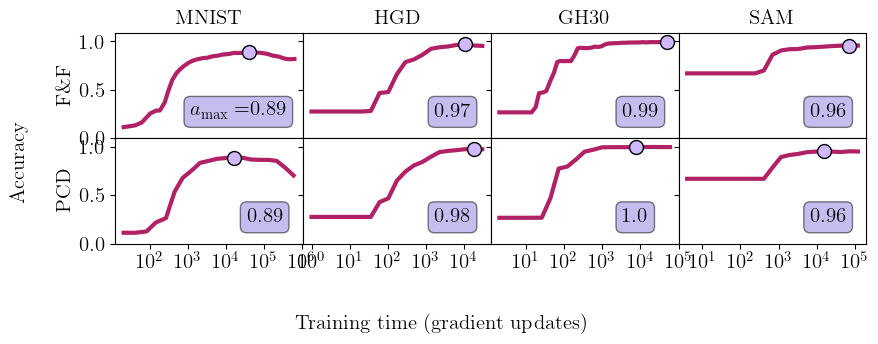

In [129]:
fig = plt.figure(dpi=100, figsize=(9,3.5))
gs = fig.add_gridspec(2, 4, hspace=0, wspace=0)
ax = gs.subplots(sharex='col', sharey='row')
c1 = '#B02166'
c2 = '#D0BAFF'
props = dict(boxstyle='round', facecolor='#897FDE', alpha=0.5)


#fig, ax = plt.subplots(dpi=100, nrows=1, ncols=4, figsize=(8,2.7))

# MNIST
dataset_name = 'MNIST'
ax[0, 0].set_title(dataset_name, size=15)
ax[0, 0].set_xscale('log')
ax[0, 0].set_ylabel('F\&F')
acc_max_idx = np.argmax(acc_lists_Rdm[dataset_name])
t_acc_max = alltimes_Rdm[dataset_name][acc_max_idx]
acc_max = float(acc_lists_Rdm[dataset_name][acc_max_idx])
ax[0, 0].plot(np.array(alltimes_Rdm[dataset_name]), acc_lists_Rdm[dataset_name], lw=3, zorder=0, color=c1)
ax[0, 0].scatter(t_acc_max, acc_max, color=c2, s=100, zorder=1, edgecolors='black')
bottom, top = plt.ylim()
ax[0, 0].set_ylim(0, 1.09)
ax[0, 0].set_yticks([0., 0.5, 1.])
ax[0, 0].annotate(r'$a_{\mathrm{max}}=$' + f'{round(acc_max,2)}', xy=(t_acc_max, acc_max), xytext=(0.4, 0.2), xycoords='axes fraction', bbox=props)
print(f'max accuracy {dataset_name} Rdm: {round(acc_max,2)} at epoch {t_acc_max}')

# DNA
dataset_name = 'HGD'
ax[0, 1].set_title(dataset_name, size=15)
ax[0, 1].set_xscale('log')
acc_max_idx = np.argmax(acc_lists_Rdm[dataset_name])
t_acc_max = alltimes_Rdm[dataset_name][acc_max_idx]
acc_max = float(acc_lists_Rdm[dataset_name][acc_max_idx])
ax[0, 1].plot(np.array(alltimes_Rdm[dataset_name]), acc_lists_Rdm[dataset_name], lw=3, zorder=0, color=c1)
ax[0, 1].scatter(t_acc_max, acc_max, color=c2, s=100, zorder=1, edgecolors='black')
ax[0, 1].annotate(f'{round(acc_max,2)}', xy=(t_acc_max, acc_max), xytext=(0.7, 0.2), xycoords='axes fraction', bbox=props)
print(f'max accuracy {dataset_name} Rdm: {round(acc_max,2)} at epoch {t_acc_max}')

# GH30
dataset_name = 'GH30'
ax[0, 2].set_title(dataset_name, size=15)
ax[0, 2].set_xscale('log')
acc_max_idx = np.argmax(acc_lists_Rdm[dataset_name])
t_acc_max = alltimes_Rdm[dataset_name][acc_max_idx]
acc_max = float(acc_lists_Rdm[dataset_name][acc_max_idx])
ax[0, 2].plot(np.array(alltimes_Rdm[dataset_name]), acc_lists_Rdm[dataset_name], lw=3, zorder=0, color=c1)
ax[0, 2].scatter(t_acc_max, acc_max, color=c2, s=100, zorder=1, edgecolors='black')
ax[0, 2].annotate(f'{round(acc_max,2)}', xy=(t_acc_max, acc_max), xytext=(0.7, 0.2), xycoords='axes fraction', bbox=props)
print(f'max accuracy {dataset_name} Rdm: {round(acc_max,2)} at epoch {t_acc_max}')

# SAM
dataset_name = 'SAM'
ax[0, 3].set_title(dataset_name, size=15)
ax[0, 3].set_xscale('log')
acc_max_idx = np.argmax(acc_lists_Rdm[dataset_name])
t_acc_max = alltimes_Rdm[dataset_name][acc_max_idx]
acc_max = float(acc_lists_Rdm[dataset_name][acc_max_idx])
ax[0, 3].plot(np.array(alltimes_Rdm[dataset_name]), acc_lists_Rdm[dataset_name], lw=3, zorder=0, color=c1)
ax[0, 3].scatter(t_acc_max, acc_max, color=c2, s=100, zorder=1, edgecolors='black')
ax[0, 3].annotate(f'{round(acc_max,2)}', xy=(t_acc_max, acc_max), xytext=(0.7, 0.2), xycoords='axes fraction', bbox=props)
print(f'max accuracy {dataset_name} Rdm: {round(acc_max,2)} at epoch {t_acc_max}')

###########################################################

# MNIST
dataset_name = 'MNIST'
ax[1, 0].set_xscale('log')
ax[1, 0].set_ylabel('PCD')
acc_max_idx = np.argmax(acc_lists_PCD[dataset_name])
t_acc_max = alltimes_PCD[dataset_name][acc_max_idx]
acc_max = float(acc_lists_PCD[dataset_name][acc_max_idx])
ax[1, 0].plot(np.array(alltimes_PCD[dataset_name]), acc_lists_PCD[dataset_name], lw=3, zorder=0, color=c1)
ax[1, 0].scatter(t_acc_max, acc_max, color=c2, s=100, zorder=1, edgecolors='black')
bottom, top = plt.ylim()
ax[1, 0].set_ylim(0, 1.09)
ax[1, 0].set_yticks([0., 0.5, 1.])
ax[1, 0].annotate(f'{round(acc_max,2)}', xy=(t_acc_max, acc_max), xytext=(0.7, 0.2), xycoords='axes fraction', bbox=props)
print(f'max accuracy {dataset_name} PCD: {round(acc_max,2)} at epoch {t_acc_max}')

# DNA
dataset_name = 'HGD'
ax[1, 1].set_xscale('log')
acc_max_idx = np.argmax(acc_lists_PCD[dataset_name])
t_acc_max = alltimes_PCD[dataset_name][acc_max_idx]
acc_max = float(acc_lists_PCD[dataset_name][acc_max_idx])
ax[1, 1].plot(np.array(alltimes_PCD[dataset_name]), acc_lists_PCD[dataset_name], lw=3, zorder=0, color=c1)
ax[1, 1].scatter(t_acc_max, acc_max, color=c2, s=100, zorder=1, edgecolors='black')
ax[1, 1].annotate(f'{round(acc_max,2)}', xy=(t_acc_max, acc_max), xytext=(0.7, 0.2), xycoords='axes fraction', bbox=props)
print(f'max accuracy {dataset_name} PCD: {round(acc_max,2)} at epoch {t_acc_max}')

# GH30
dataset_name = 'GH30'
ax[1, 2].set_xscale('log')
acc_max_idx = np.argmax(acc_lists_PCD[dataset_name])
t_acc_max = alltimes_PCD[dataset_name][acc_max_idx]
acc_max = float(acc_lists_PCD[dataset_name][acc_max_idx])
ax[1, 2].plot(np.array(alltimes_PCD[dataset_name]), acc_lists_PCD[dataset_name], lw=3, zorder=0, color=c1)
ax[1, 2].scatter(t_acc_max, acc_max, color=c2, s=100, zorder=1, edgecolors='black')
ax[1, 2].annotate(f'{round(acc_max,2)}', xy=(t_acc_max, acc_max), xytext=(0.7, 0.2), xycoords='axes fraction', bbox=props)
print(f'max accuracy {dataset_name} PCD: {round(acc_max,2)} at epoch {t_acc_max}')

# SAM
dataset_name = 'SAM'
ax[1, 3].set_xscale('log')
acc_max_idx = np.argmax(acc_lists_PCD[dataset_name])
t_acc_max = alltimes_PCD[dataset_name][acc_max_idx]
acc_max = float(acc_lists_PCD[dataset_name][acc_max_idx])
ax[1, 3].plot(np.array(alltimes_PCD[dataset_name]), acc_lists_PCD[dataset_name], lw=3, zorder=0, color=c1)
ax[1, 3].scatter(t_acc_max, acc_max, color=c2, s=100, zorder=1, edgecolors='black')
ax[1, 3].annotate(f'{round(acc_max,2)}', xy=(t_acc_max, acc_max), xytext=(0.7, 0.2), xycoords='axes fraction', bbox=props)
print(f'max accuracy {dataset_name} PCD: {round(acc_max,2)} at epoch {t_acc_max}')

for j in range(4):
    ax[1, j].xaxis.set_major_locator(LogLocator(base=10.0, numticks=20))
    #ax[i, j].xaxis.set_minor_locator(LogLocator(base=10.0, numticks=10))

fig.supxlabel('Training time (gradient updates)', size=15)
fig.supylabel('Accuracy', size=15)
fig.tight_layout()
fig.savefig('/home/lorenzo.rosset/Documents/drawings/FeF/svg/accuracies_vs_time.svg')

### Accuaracy vs generation time

In [123]:
def get_acc_vs_time(fname_model, fname_data, data_type, RBM_type, eval_times):
    f = h5py.File(fname_data, 'r')
    data_set = 'test'
    X_data = torch.tensor(f[data_set][()], device=device, dtype=data_type)
    labels_data_string = f[data_set + '_labels'].asstr()[()]
    lab2num = {l : i for i, l in enumerate(np.unique(labels_data_string))}
    labels_data = torch.tensor([lab2num[l] for l in labels_data_string], device=device, dtype=torch.int64)
    rbm = RBM_type(device=device)
    rbm.loadRBM(fname_model, stamp=30000)
    
    acc_list = np.array([])
    L = torch.randint(0, rbm.num_categ, size=(X_data.shape[0],), device=device).type(torch.int64)
    for tg_index in range(1, len(eval_times)):
        dt = (eval_times[tg_index] - eval_times[tg_index - 1])
        L = rbm.predict(X_data, L, it_mcmc=dt).argmax(-1)
        accuracy = ((labels_data == L).sum() / len(labels_data)).cpu().numpy()
        acc_list = np.append(acc_list, accuracy)
    
    return acc_list

In [132]:
# Rdm

## HGD
eval_times = np.unique(np.logspace(0, 3, 50).astype(int))
fname_model = 'models/DNA/BernoulliBernoulliSslRBM-2023.5.24.10.44-DNA-ep30000-lr0.01-Nh1024-NGibbs10-mbs4507-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-Rdm.h5'
fname_data = 'data/DNA.h5'
data_type = torch.float32
RBM = importlib.import_module('BernoulliBernoulliSslRBM').RBM
acc_HGD_Rdm = get_acc_vs_time(fname_model, fname_data, data_type, RBM, eval_times)

## MNIST
eval_times_MNIST = np.unique(np.logspace(0, 4, 50).astype(int))
fname_model = 'models/MNIST/BernoulliBernoulliSslRBM-2023.5.11.17.38-MNIST-ep100000-lr0.01-Nh1000-NGibbs10-mbs500-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-Rdm.h5'
dataset_name = 'MNIST'
fname_data = 'data/MNIST.h5'
data_type = torch.float32
RBM = importlib.import_module('BernoulliBernoulliSslRBM').RBM
acc_MNIST_Rdm = get_acc_vs_time(fname_model, fname_data, data_type, RBM, eval_times_MNIST)

## GH30
fname_model = 'models/GH30_annotated/PottsBernoulliSslRBM-2023.5.4.23.8-GH30_annotated-ep30000-lr0.01-Nh1024-NGibbs10-mbs1961-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-Rdm.h5'
dataset_name = 'GH30'
fname_data = 'data/GH30_annotated.h5'
data_type = torch.int64
RBM = importlib.import_module('PottsBernoulliSslRBM').RBM
acc_GH30_Rdm = get_acc_vs_time(fname_model, fname_data, data_type, RBM, eval_times)

## SAM
fname_model = 'models/SAM/PottsBernoulliSslRBM-2023.7.5.14.19-SAM-ep30000-lr0.01-Nh100-NGibbs10-mbs1000-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-Rdm.h5'
dataset_name = 'SAM'
fname_data = 'data/SAM.h5'
data_type = torch.int64
RBM = importlib.import_module('PottsBernoulliSslRBM').RBM
acc_SAM_Rdm = get_acc_vs_time(fname_model, fname_data, data_type, RBM, eval_times)

# PCD

## HGD
fname_model = 'models/DNA/BernoulliBernoulliSslRBM-2023.6.20.12.3-DNA-ep30000-lr0.01-Nh1024-NGibbs100-mbs4507-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-PCD.h5'
fname_data = 'data/DNA.h5'
data_type = torch.float32
RBM = importlib.import_module('BernoulliBernoulliSslRBM').RBM
acc_HGD_PCD = get_acc_vs_time(fname_model, fname_data, data_type, RBM, eval_times)

## MNIST
fname_model = 'models/MNIST/BernoulliBernoulliSslRBM-2023.6.21.13.16-MNIST-ep30000-lr0.01-Nh1024-NGibbs100-mbs500-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-PCD.h5'
dataset_name = 'MNIST'
fname_data = 'data/MNIST.h5'
data_type = torch.float32
RBM = importlib.import_module('BernoulliBernoulliSslRBM').RBM
acc_MNIST_PCD = get_acc_vs_time(fname_model, fname_data, data_type, RBM, eval_times_MNIST)

## GH30
fname_model = 'models/GH30_annotated/PottsBernoulliSslRBM-2023.6.20.10.38-GH30_annotated-ep30000-lr0.01-Nh1024-NGibbs100-mbs1961-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-PCD.h5'
dataset_name = 'GH30'
fname_data = 'data/GH30_annotated.h5'
data_type = torch.int64
RBM = importlib.import_module('PottsBernoulliSslRBM').RBM
acc_GH30_PCD = get_acc_vs_time(fname_model, fname_data, data_type, RBM, eval_times)

## SAM
fname_model = 'models/SAM/PottsBernoulliSslRBM-2023.7.5.16.20-SAM-ep30000-lr0.01-Nh100-NGibbs100-mbs1000-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-PCD.h5'
dataset_name = 'SAM'
fname_data = 'data/SAM.h5'
data_type = torch.int64
RBM = importlib.import_module('PottsBernoulliSslRBM').RBM
acc_SAM_PCD = get_acc_vs_time(fname_model, fname_data, data_type, RBM, eval_times)


eval_times = eval_times[1:]
eval_times_MNIST = eval_times_MNIST[1:]

max accuracy MNIST Rdm: 0.86 at epoch 5689
max accuracy HGD Rdm: 0.97 at epoch 68
max accuracy GH30 Rdm: 0.99 at epoch 2
max accuracy SAM Rdm: 0.97 at epoch 22
max accuracy MNIST PCD: 0.89 at epoch 10000
max accuracy HGD PCD: 0.98 at epoch 14
max accuracy GH30 PCD: 1.0 at epoch 2
max accuracy SAM PCD: 0.97 at epoch 159


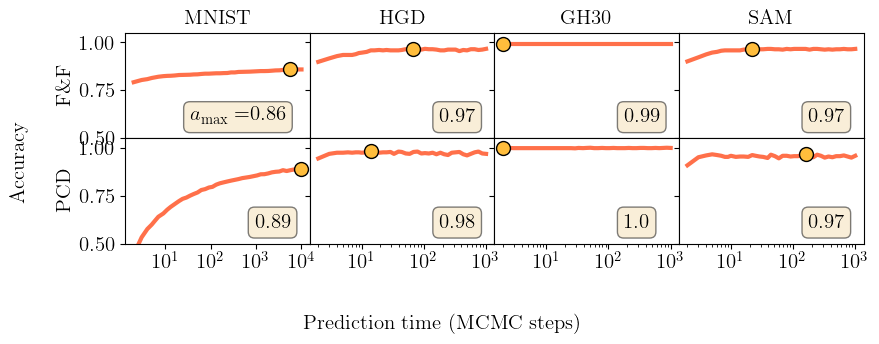

In [134]:
fig = plt.figure(dpi=100, figsize=(9,3.5))
gs = fig.add_gridspec(2, 4, hspace=0, wspace=0)
ax = gs.subplots(sharex='col', sharey='row')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
c1 = '#FF704A'
c2 = '#FFBD3C'

# Rdm

# MNIST
dataset_name = 'MNIST'
ax[0, 0].set_title(dataset_name, size=15)
ax[0, 0].set_xscale('log')
ax[0, 0].set_ylabel('F\&F')
acc_max_idx = np.argmax(acc_MNIST_Rdm)
t_acc_max = eval_times_MNIST[acc_max_idx]
acc_max = acc_MNIST_Rdm[acc_max_idx]
ax[0, 0].plot(eval_times_MNIST, acc_MNIST_Rdm, lw=3, zorder=0, color=c1)
ax[0, 0].scatter(t_acc_max, acc_max, color=c2, s=100, zorder=1, edgecolors='black')
bottom, top = plt.ylim()
#ax[0, 0].set_ylim(0, 1.07)
#ax[0, 0].set_yticks([0., 0.5, 1.])
ax[0, 0].annotate(r'$a_{\mathrm{max}}=$' + f'{round(acc_max,2)}', xy=(t_acc_max, acc_max), xytext=(0.35, 0.15), xycoords='axes fraction', bbox=props)
print(f'max accuracy {dataset_name} Rdm: {round(acc_max,2)} at epoch {t_acc_max}')

# DNA
dataset_name = 'HGD'
ax[0, 1].set_title(dataset_name, size=15)
ax[0, 1].set_xscale('log')
acc_max_idx = np.argmax(acc_HGD_Rdm)
t_acc_max = eval_times[acc_max_idx]
acc_max = acc_HGD_Rdm[acc_max_idx]
ax[0, 1].plot(eval_times, acc_HGD_Rdm, lw=3, zorder=0, color=c1)
ax[0, 1].scatter(t_acc_max, acc_max, color=c2, s=100, zorder=1, edgecolors='black')
bottom, top = plt.ylim()
#ax[0, 1].set_ylim(0, 1.07)
#ax[0, 1].set_yticks([0., 0.5, 1.])
ax[0, 1].annotate(f'{round(acc_max,2)}', xy=(t_acc_max, acc_max), xytext=(0.7, 0.15), xycoords='axes fraction', bbox=props)
print(f'max accuracy {dataset_name} Rdm: {round(acc_max,2)} at epoch {t_acc_max}')

# GH30
dataset_name = 'GH30'
ax[0, 2].set_title(dataset_name, size=15)
ax[0, 2].set_xscale('log')
acc_max_idx = np.argmax(acc_GH30_Rdm)
t_acc_max = eval_times[acc_max_idx]
acc_max = acc_GH30_Rdm[acc_max_idx]
ax[0, 2].plot(eval_times, acc_GH30_Rdm, lw=3, zorder=0, color=c1)
ax[0, 2].scatter(t_acc_max, acc_max, color=c2, s=100, zorder=1, edgecolors='black')
bottom, top = plt.ylim()
#ax[0, 2].set_ylim(0, 1.07)
#ax[0, 2].set_yticks([0., 0.5, 1.])
ax[0, 2].annotate(f'{round(acc_max,2)}', xy=(t_acc_max, acc_max), xytext=(0.7, 0.15), xycoords='axes fraction', bbox=props)
print(f'max accuracy {dataset_name} Rdm: {round(acc_max,2)} at epoch {t_acc_max}')

# SAM
dataset_name = 'SAM'
ax[0, 3].set_title(dataset_name, size=15)
ax[0, 3].set_xscale('log')
acc_max_idx = np.argmax(acc_SAM_Rdm)
t_acc_max = eval_times[acc_max_idx]
acc_max = acc_SAM_Rdm[acc_max_idx]
ax[0, 3].plot(eval_times, acc_SAM_Rdm, lw=3, zorder=0, color=c1)
ax[0, 3].scatter(t_acc_max, acc_max, color=c2, s=100, zorder=1, edgecolors='black')
bottom, top = plt.ylim()
#ax[0, 3].set_yticks([0., 0.5, 1.])
ax[0, 3].annotate(f'{round(acc_max,2)}', xy=(t_acc_max, acc_max), xytext=(0.7, 0.15), xycoords='axes fraction', bbox=props)
print(f'max accuracy {dataset_name} Rdm: {round(acc_max,2)} at epoch {t_acc_max}')

######################################################################################

# PCD

# MNIST
dataset_name = 'MNIST'
ax[1, 0].set_xscale('log')
ax[1, 0].set_ylabel('PCD')
acc_max_idx = np.argmax(acc_MNIST_PCD)
t_acc_max = eval_times_MNIST[acc_max_idx]
acc_max = acc_MNIST_PCD[acc_max_idx]
ax[1, 0].plot(eval_times_MNIST, acc_MNIST_PCD, lw=3, zorder=0, color=c1)
ax[1, 0].scatter(t_acc_max, acc_max, color=c2, s=100, zorder=1, edgecolors='black')
bottom, top = plt.ylim()
#ax[0, 0].set_ylim(0, 1.07)
#ax[0, 0].set_yticks([0., 0.5, 1.])
ax[1, 0].annotate(f'{round(acc_max,2)}', xy=(t_acc_max, acc_max), xytext=(0.7, 0.15), xycoords='axes fraction', bbox=props)
print(f'max accuracy {dataset_name} PCD: {round(acc_max,2)} at epoch {t_acc_max}')

# DNA
dataset_name = 'HGD'
ax[1, 1].set_xscale('log')
acc_max_idx = np.argmax(acc_HGD_PCD)
t_acc_max = eval_times[acc_max_idx]
acc_max = acc_HGD_PCD[acc_max_idx]
ax[1, 1].plot(eval_times, acc_HGD_PCD, lw=3, zorder=0, color=c1)
ax[1, 1].scatter(t_acc_max, acc_max, color=c2, s=100, zorder=1, edgecolors='black')
bottom, top = plt.ylim()
#ax[0, 1].set_ylim(0, 1.07)
#ax[0, 1].set_yticks([0., 0.5, 1.])
ax[1, 1].annotate(f'{round(acc_max,2)}', xy=(t_acc_max, acc_max), xytext=(0.7, 0.15), xycoords='axes fraction', bbox=props)
print(f'max accuracy {dataset_name} PCD: {round(acc_max,2)} at epoch {t_acc_max}')

# GH30
dataset_name = 'GH30'
ax[1, 2].set_xscale('log')
acc_max_idx = np.argmax(acc_GH30_PCD)
t_acc_max = eval_times[acc_max_idx]
acc_max = acc_GH30_PCD[acc_max_idx]
ax[1, 2].plot(eval_times, acc_GH30_PCD, lw=3, zorder=0, color=c1)
ax[1, 2].scatter(t_acc_max, acc_max, color=c2, s=100, zorder=1, edgecolors='black')
bottom, top = plt.ylim()
#ax[0, 2].set_ylim(0, 1.07)
#ax[0, 2].set_yticks([0., 0.5, 1.])
ax[1, 2].annotate(f'{round(acc_max,2)}', xy=(t_acc_max, acc_max), xytext=(0.7, 0.15), xycoords='axes fraction', bbox=props)
print(f'max accuracy {dataset_name} PCD: {round(acc_max,2)} at epoch {t_acc_max}')

# SAM
dataset_name = 'SAM'
ax[1, 3].set_xscale('log')
acc_max_idx = np.argmax(acc_SAM_PCD)
t_acc_max = eval_times[acc_max_idx]
acc_max = acc_SAM_PCD[acc_max_idx]
ax[1, 3].plot(eval_times, acc_SAM_PCD, lw=3, zorder=0, color=c1)
ax[1, 3].scatter(t_acc_max, acc_max, color=c2, s=100, zorder=1, edgecolors='black')
bottom, top = plt.ylim()
#ax[0, 3].set_yticks([0., 0.5, 1.])
ax[1, 3].annotate(f'{round(acc_max,2)}', xy=(t_acc_max, acc_max), xytext=(0.7, 0.15), xycoords='axes fraction', bbox=props)
print(f'max accuracy {dataset_name} PCD: {round(acc_max,2)} at epoch {t_acc_max}')

ax[0, 0].set_yticks([0.5, 0.75, 1.])
ax[1, 0].set_yticks([0.5, 0.75, 1.])
ax[1, 3].set_ylim(0.5, 1.05)
ax[0, 3].set_ylim(0.5, 1.05)
ax[1, 0].xaxis.set_major_locator(LogLocator(base=10.0, numticks=20))
fig.supxlabel('Prediction time (MCMC steps)', size=15)
fig.supylabel('Accuracy', size=15)
fig.tight_layout()
fig.savefig('/home/lorenzo.rosset/Documents/drawings/FeF/svg/accuracies_vs_sampling_time.svg')

### Genearating data as a function of sampling time

generating data

In [75]:
def get_samples_vs_time(fname_model, fname_data, data_type, RBM_type, eval_times):
    f_data = h5py.File(fname_data, 'r')
    n_data = 3000
    all_labels_data = f_data[data_type + '_labels'].asstr()[()]
    labels_data = all_labels_data[:n_data]
    label2num = {lab : i for i, lab in enumerate(np.unique(labels_data))}
    rbm = RBM_type(device=device)
    rbm.loadRBM(fname_model, stamp=30000)
    
    samples_list = []
    targets = torch.tensor([label2num[l] for l in labels_data], device=device, dtype=torch.int64)
    gen_data = torch.randint(0, rbm.num_states, size=(len(targets), rbm.Nv), device=device).type(torch.int64)
    for tg_index in range(1, len(eval_times)):
        dt = (eval_times[tg_index] - eval_times[tg_index - 1])
        gen_data, *_ = rbm.conditioned_sampling(gen_data, targets, it_mcmc=dt)
        samples_list.append(gen_data.cpu().numpy())
    
    return samples_list, targets.cpu().numpy()

In [167]:
def plot_scatter_labels(ax, data_proj, gen_data_proj, proj1, proj2):    
    for lab in unique_labels:
        idx = np.where(lab == labels_data)[0]
        ax.scatter(data_proj[idx, proj1], data_proj[idx, proj2], color=colors_dict[lab], s=50, zorder=0, alpha=0.3)
        idx = np.where(label2num[lab] == targets)[0]
        ax.scatter(gen_data_proj[idx, proj1], gen_data_proj[idx, proj2], color=colors_dict[lab], label=lab, s=20, zorder=2, edgecolor='black', marker='o', alpha=1, linewidth=0.4)
    
def plot_hist(ax, data_proj, gen_data_proj, color, proj, orientation='vertical'):    
    ax.hist(data_proj[:, proj], bins=40, color='black', histtype='step', label='data', zorder=0, density=True, orientation=orientation, lw=1)
    ax.hist(gen_data_proj[:, proj], bins=40, color=color, histtype='step', label='generated', zorder=1, density=True, orientation=orientation, lw=1.5)
    ax.axis('off')

#### SAM

In [219]:
file_data = 'results/sampling_vs_time/SAM_sampling.h5'
#eval_times = [0, 10, 100, 1000, 10000, 100000]
eval_times = [0, 10, 100, 1000, 10000, 100000]

# to change
RBM = importlib.import_module('PottsBernoulliSslRBM').RBM
device = torch.device('cuda:1')
fname_model = 'models/SAM/PottsBernoulliSslRBM-2023.7.5.16.20-SAM-ep30000-lr0.01-Nh100-NGibbs100-mbs1000-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-PCD.h5'
fname_data = 'data/SAM.h5'
data_type = 'train'
n_data = 3000
f_data = h5py.File(fname_data, 'r')
f_model = h5py.File(fname_model, 'r')
all_X_data = np.array(f_data[data_type]).astype(np.float32)
all_labels_data = f_data[data_type + '_labels'].asstr()[()]

X_data = torch.tensor(all_X_data[:n_data], device=device, dtype=torch.int64)
labels_data = all_labels_data[:n_data]
unique_labels = np.unique(labels_data)
leaves_names = f_data[data_type + '_names'].asstr()[:n_data]

X_data_oh = one_hot(X_data).reshape(X_data.shape[0], -1).float()
_, S_data, V_data = torch.svd(X_data_oh - X_data_oh.mean(0))
V_data /= X_data.shape[1]**0.5

data_proj = X_data_oh @ V_data
data_proj = data_proj.cpu().numpy()

In [220]:
fname_import_SAM = 'results/sampling_vs_time/SAM_sampling.h5'
f_import_SAM = h5py.File(fname_import_SAM, 'r')

KeyError: 'Actinomycetota'

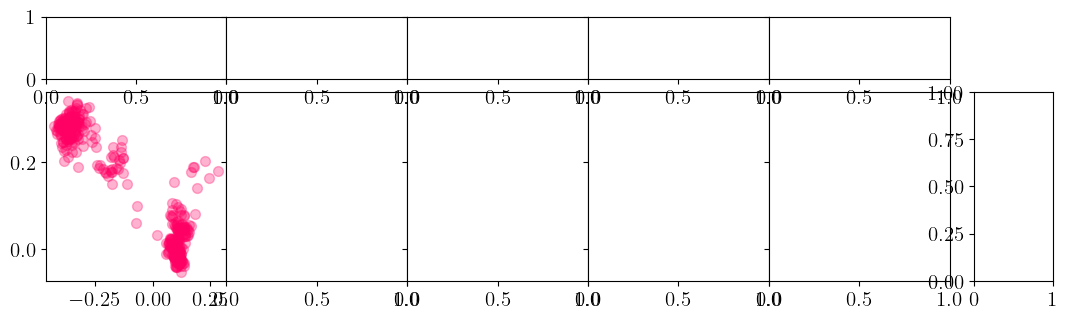

In [221]:
# gridspec inside gridspec
fig = plt.figure(figsize=(13, 3.5), dpi=100)
gs_global = gridspec.GridSpec(2, 2, figure=fig, width_ratios=(4,0.35), height_ratios=(1,3), wspace=0.05, hspace=0.1)
gs_scatter = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=gs_global[1, 0], wspace=0, hspace=0)
ax_scatter = gs_scatter.subplots(sharex='col', sharey='row')
gs_hist_top = gs_global[0, 0].subgridspec(1, 5, wspace=0, hspace=0)
ax_hist_top = gs_hist_top.subplots(sharex='col', sharey='row')
ax_hist_side = fig.add_subplot(gs_global[1, 1])

eval_times = [10, 100, 1000, 10000, 100000]
colors = ['#FF0064', '#DE4C08', '#A07100', '#538200', '#008579']
colors_dict = {lab : colors[i] for i, lab in enumerate(unique_labels)}
colors_hist = cm.get_cmap('RdYlBu', 5)

for i, et in enumerate(eval_times):
    props = dict(boxstyle='round', facecolor=colors_hist(i), alpha=0.5)
    gen_data = torch.tensor(f_import_SAM[str(et)][()], dtype=torch.int64, device=device)
    targets = f_import_SAM['labels'][()]
    gen_data_oh = one_hot(gen_data).reshape(gen_data.shape[0], -1).float()
    gen_data_proj = gen_data_oh @ V_data
    gen_data_proj = gen_data_proj.cpu().numpy()
    plot_scatter_labels(ax_scatter[i], data_proj, gen_data_proj, 0, 1)
    plot_hist(ax_hist_top[i], data_proj, gen_data_proj, color=colors_hist(i), proj=0, orientation='vertical')
    plot_hist(ax_hist_side, data_proj, gen_data_proj, color=colors_hist(i), proj=0, orientation='horizontal')
    ax_scatter[i].annotate(r'$t_{\mathrm{G}}=$' + fr'$10^{i+1}$', xy=(0.1, 0.1), xycoords='axes fraction', bbox=props, size=12)
    ax_scatter[i].set_xticks(np.arange(-0.5, 0.5, 0.5))
    
ax_scatter[0].set_yticks(np.arange(-0.5, 0.5, 0.2))
ax_scatter[4].set_xticks(np.arange(-0.5, 0.6, 0.5))
ax_scatter[2].set_xlabel('1 PC')
ax_scatter[0].set_ylabel('2 PC')

#fig.savefig('/home/lorenzo.rosset/Documents/drawings/FeF/svg/SAM_sequence_generation.svg')

#### GH30

In [211]:
file_data = 'results/sampling_vs_time/GH30_sampling.h5'
#eval_times = [0, 10, 100, 1000, 10000, 100000]
eval_times = [0, 10, 100, 1000, 10000, 100000]

# to change
RBM = importlib.import_module('PottsBernoulliSslRBM').RBM
device = torch.device('cuda:1')
fname_model = 'models/GH30_annotated/PottsBernoulliSslRBM-2023.6.20.10.38-GH30_annotated-ep30000-lr0.01-Nh1024-NGibbs100-mbs1961-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-PCD.h5'
fname_data = 'data/GH30_annotated.h5'
data_type = 'test'
n_data = 3000
f_data = h5py.File(fname_data, 'r')
f_model = h5py.File(fname_model, 'r')
all_X_data = np.array(f_data[data_type]).astype(np.float32)
all_labels_data = f_data[data_type + '_labels'].asstr()[()]

X_data = torch.tensor(all_X_data[:n_data], device=device, dtype=torch.int64)
labels_data = all_labels_data[:n_data]
unique_labels = np.unique(labels_data)
leaves_names = f_data[data_type + '_names'].asstr()[:n_data]

X_data_oh = one_hot(X_data).reshape(X_data.shape[0], -1).float()
_, S_data, V_data = torch.svd(X_data_oh - X_data_oh.mean(0))
V_data /= X_data.shape[1]**0.5

data_proj = X_data_oh @ V_data
data_proj = data_proj.cpu().numpy()

In [ ]:
samples_list_GH30, targets_GH30 = get_samples_vs_time(fname_model, fname_data, data_type, RBM, eval_times)
eval_times = eval_times[1:]
# save data
f = h5py.File(file_data, 'w')
for i in range(len(eval_times)):
    f[str(eval_times[i])] = samples_list_GH30[i]

f['labels'] = targets_GH30
f.close()

In [207]:
fname_import_GH30 = 'results/sampling_vs_time/GH30_sampling.h5'
f_import_GH30 = h5py.File(fname_import_GH30, 'r')

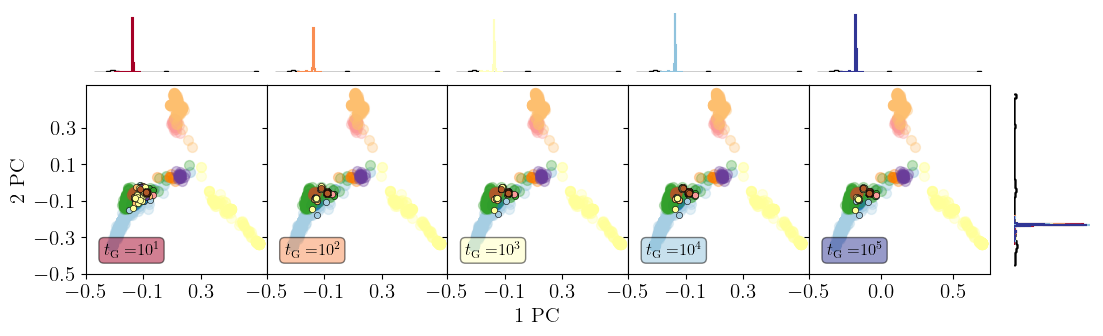

In [215]:
# gridspec inside gridspec
fig = plt.figure(figsize=(13, 3.5), dpi=100)
gs_global = gridspec.GridSpec(2, 2, figure=fig, width_ratios=(4,0.35), height_ratios=(1,3), wspace=0.05, hspace=0.1)
gs_scatter = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=gs_global[1, 0], wspace=0, hspace=0)
ax_scatter = gs_scatter.subplots(sharex='col', sharey='row')
gs_hist_top = gs_global[0, 0].subgridspec(1, 5, wspace=0, hspace=0)
ax_hist_top = gs_hist_top.subplots(sharex='col', sharey='row')
ax_hist_side = fig.add_subplot(gs_global[1, 1])

eval_times = [10, 100, 1000, 10000, 100000]
colors = cm.get_cmap('Paired', len(unique_labels))
colors_dict = {lab : colors(i) for i, lab in enumerate(unique_labels)}
colors_hist = cm.get_cmap('RdYlBu', 5)

for i, et in enumerate(eval_times):
    props = dict(boxstyle='round', facecolor=colors_hist(i), alpha=0.5)
    gen_data = torch.tensor(f_import_GH30[str(et)][()], dtype=torch.int64, device=device)
    targets = f_import_GH30['labels'][()]
    gen_data_oh = one_hot(gen_data).reshape(gen_data.shape[0], -1).float()
    gen_data_proj = gen_data_oh @ V_data
    gen_data_proj = gen_data_proj.cpu().numpy()
    plot_scatter_labels(ax_scatter[i], data_proj, gen_data_proj, 0, 1)
    plot_hist(ax_hist_top[i], data_proj, gen_data_proj, color=colors_hist(i), proj=0, orientation='vertical')
    plot_hist(ax_hist_side, data_proj, gen_data_proj, color=colors_hist(i), proj=0, orientation='horizontal')
    ax_scatter[i].annotate(r'$t_{\mathrm{G}}=$' + fr'$10^{i+1}$', xy=(0.1, 0.1), xycoords='axes fraction', bbox=props, size=12)
    ax_scatter[i].set_xticks(np.arange(-0.5, 0.5, 0.4))
    
ax_scatter[0].set_yticks(np.arange(-0.5, 0.5, 0.2))
ax_scatter[4].set_xticks(np.arange(-0.5, 0.6, 0.5))
ax_scatter[2].set_xlabel('1 PC')
ax_scatter[0].set_ylabel('2 PC')

fig.savefig('/home/lorenzo.rosset/Documents/drawings/FeF/svg/GH30_sequence_generation.svg')